# Amazon Apparel Recommendations

In [1]:
#import all the necessary packages.

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [2]:
# loading the data using pandas' read_json file.
data = pd.read_json('tops_fashion.json')


In [3]:
print ('Number of data points/products/rows : ', data.shape[0], \
       'Number of features/variables/columns:', data.shape[1])

Number of data points/products/rows :  183138 Number of features/variables/columns: 19


In [4]:
# each product/item has 19 features in the raw dataset.
data.columns # prints column-names or feature-names.

Index(['asin', 'author', 'availability', 'availability_type', 'brand', 'color',
       'editorial_reivew', 'editorial_review', 'formatted_price',
       'large_image_url', 'manufacturer', 'medium_image_url', 'model',
       'product_type_name', 'publisher', 'reviews', 'sku', 'small_image_url',
       'title'],
      dtype='object')

Of these 19 features, we will be using only 6 features
1. asin  ( Amazon standard identification number)
2. brand ( brand to which the product belongs to )
3. color ( Color information of apparel, it can contain many colors as a value ex: red and black stripes ) 
4. product_type_name (type of the apperal, ex: SHIRT/TSHIRT )
5. medium_image_url  ( url of the image )
6. title (title of the product.)
7. formatted_price (price of the product)

In [5]:
#split the data into the new dataset which have only the required feature
data = data[['asin', 'brand', 'color', 'medium_image_url', 'product_type_name', 'title', 'formatted_price']]

In [6]:
print ('Number of data points : ', data.shape[0], \
       'Number of features:', data.shape[1])
data.head() # prints the top 5 rows in the table.

Number of data points :  183138 Number of features: 7


asin         brand              color  \
0  B016I2TS4W         FNC7C               None   
1  B01N49AI08  FIG Clothing               None   
2  B01JDPCOHO  FIG Clothing               None   
3  B01N19U5H5       Focal18               None   
4  B004GSI2OS   FeatherLite  Onyx Black/ Stone   

                                    medium_image_url product_type_name  \
0  https://images-na.ssl-images-amazon.com/images...             SHIRT   
1  https://images-na.ssl-images-amazon.com/images...             SHIRT   
2  https://images-na.ssl-images-amazon.com/images...             SHIRT   
3  https://images-na.ssl-images-amazon.com/images...             SHIRT   
4  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                               title formatted_price  
0  Minions Como Superheroes Ironman Long Sleeve R...            None  
1                      FIG Clothing Womens Izo Tunic            None  
2                        FIG Clothing Womens Won Top            None  
3  Focal18 Sailor Collar Bubble Sleeve Blouse Shi...            None  
4  Featherlite Ladies' Long Sleeve Stain Resistan...          $26.26

In [7]:
data.tail() #prints last five rows from the dataset

asin          brand             color  \
183133  B01MSALTSO      TOOGOO(R)             Black   
183134  B015W98YQK     VOGUE CODE  Monochrome Plaid   
183135  B075756PGC       Wrangler              Pink   
183136  B074L8FVTT  susana monaco              Rose   
183137  B074FTYJQC       Sexybaby              None   

                                         medium_image_url product_type_name  \
183133  https://images-na.ssl-images-amazon.com/images...         OUTERWEAR   
183134  https://images-na.ssl-images-amazon.com/images...             SHIRT   
183135  https://images-na.ssl-images-amazon.com/images...             SHIRT   
183136  https://images-na.ssl-images-amazon.com/images...             SHIRT   
183137  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                                    title formatted_price  
183133  TOOGOO(R) Women's Tops Spring Autumn Casual Pu...          $14.58  
183134  VOGUE CODE Vintage V Neck Plaid Shirt Sleevele...            None  
183135  Wrangler George Strait For Her Long Sleeve Pin...            None  
183136  Susana Monaco Womens Susana Monoco Sleeveless ...          $44.99  
183137  SexyBaby Women's Mesh Splive Flounced Sleeve C...            None

# Missing values of the data

#### Basic stats for the feature: product_type_name

In [8]:
# unique type of product_type_names
print(data['product_type_name'].describe())


count     183138
unique        72
top        SHIRT
freq      167794
Name: product_type_name, dtype: object


we have 72 unique type of product_type_names and top product is SHIRT, whose frequency is 167794, 
which is approx 91.62% (167794/183138) of the products.

In [9]:
# names of different product types
print(data['product_type_name'].unique())

['SHIRT' 'SWEATER' 'APPAREL' 'OUTDOOR_RECREATION_PRODUCT'
 'BOOKS_1973_AND_LATER' 'PANTS' 'HAT' 'SPORTING_GOODS' 'DRESS' 'UNDERWEAR'
 'SKIRT' 'OUTERWEAR' 'BRA' 'ACCESSORY' 'ART_SUPPLIES' 'SLEEPWEAR'
 'ORCA_SHIRT' 'HANDBAG' 'PET_SUPPLIES' 'SHOES' 'KITCHEN' 'ADULT_COSTUME'
 'HOME_BED_AND_BATH' 'MISC_OTHER' 'BLAZER' 'HEALTH_PERSONAL_CARE'
 'TOYS_AND_GAMES' 'SWIMWEAR' 'CONSUMER_ELECTRONICS' 'SHORTS' 'HOME'
 'AUTO_PART' 'OFFICE_PRODUCTS' 'ETHNIC_WEAR' 'BEAUTY'
 'INSTRUMENT_PARTS_AND_ACCESSORIES' 'POWERSPORTS_PROTECTIVE_GEAR' 'SHIRTS'
 'ABIS_APPAREL' 'AUTO_ACCESSORY' 'NONAPPARELMISC' 'TOOLS' 'BABY_PRODUCT'
 'SOCKSHOSIERY' 'POWERSPORTS_RIDING_SHIRT' 'EYEWEAR' 'SUIT'
 'OUTDOOR_LIVING' 'POWERSPORTS_RIDING_JACKET' 'HARDWARE' 'SAFETY_SUPPLY'
 'ABIS_DVD' 'VIDEO_DVD' 'GOLF_CLUB' 'MUSIC_POPULAR_VINYL'
 'HOME_FURNITURE_AND_DECOR' 'TABLET_COMPUTER' 'GUILD_ACCESSORIES'
 'ABIS_SPORTS' 'ART_AND_CRAFT_SUPPLY' 'BAG' 'MECHANICAL_COMPONENTS'
 'SOUND_AND_RECORDING_EQUIPMENT' 'COMPUTER_COMPONENT' 'JEWELRY'
 'B

In [10]:
# top 10 most frequent product_type_names.
product_type_count = Counter(list(data['product_type_name']))
product_type_count.most_common(10)

[('SHIRT', 167794),
 ('APPAREL', 3549),
 ('BOOKS_1973_AND_LATER', 3336),
 ('DRESS', 1584),
 ('SPORTING_GOODS', 1281),
 ('SWEATER', 837),
 ('OUTERWEAR', 796),
 ('OUTDOOR_RECREATION_PRODUCT', 729),
 ('ACCESSORY', 636),
 ('UNDERWEAR', 425)]

#### Basic stats for the feature: brand

In [11]:
# unique brands
print(data['brand'].describe())

count     182987
unique     10577
top         Zago
freq         223
Name: brand, dtype: object


there is 10577 unique brands in the dataset, Zago is the top brand and the frequency of it is 223.
183138-182987=151 missing values.

In [12]:
# top 10 most frequent brand name
brand_count = Counter(list(data['brand']))
brand_count.most_common(10)

[('Zago', 223),
 ('XQS', 222),
 ('Yayun', 215),
 ('YUNY', 198),
 ('XiaoTianXin-women clothes', 193),
 ('Generic', 192),
 ('Boohoo', 190),
 ('Alion', 188),
 ('Abetteric', 187),
 ('TheMogan', 187)]

#### Basic stats for the feature: color


In [13]:
print(data['color'].describe())

count     64956
unique     7380
top       Black
freq      13207
Name: color, dtype: object


we have 7380 unique colors
7.2% of products are black in color
64956 of 183138 products have brand information. That's approx 35.4%.

In [14]:
color_count = Counter(list(data['color']))
color_count.most_common(10)

[(None, 118182),
 ('Black', 13207),
 ('White', 8616),
 ('Blue', 3570),
 ('Red', 2289),
 ('Pink', 1842),
 ('Grey', 1499),
 ('*', 1388),
 ('Green', 1258),
 ('Multi', 1203)]

#### Basic stats for the feature: formatted_price

In [15]:
print(data['formatted_price'].describe())

count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object


In [16]:
price_count= Counter(list(data['formatted_price']))
price_count.most_common(10)

[(None, 154743),
 ('$19.99', 945),
 ('$9.99', 749),
 ('$9.50', 601),
 ('$14.99', 472),
 ('$7.50', 463),
 ('$24.99', 414),
 ('$29.99', 370),
 ('$8.99', 343),
 ('$9.01', 336)]

#### Basic stats for the feature: title

In [17]:
print(data['title'].describe())

count                                                183138
unique                                               175985
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object


All of the products have a title. 
Titles are fairly descriptive of what the product is.  We use titles extensively
as they are short and informative.

In [18]:
title_count = Counter(list(data['title']))
title_count.most_common(10)

[('Nakoda Cotton Self Print Straight Kurti For Women', 77),
 ("Q-rious Women's Racerback Cotton Lycra Camsioles", 56),
 ('FINEJO Casual Women Long Sleeve Lace Irregular Hem Blouse Tops', 47),
 ('Girlzwalk Women Cami Sleeveless Printed Swing Vest Top Plus Sizes', 44),
 ("ELINA FASHION Women's Indo-Western Tunic Top Cotton Kurti", 43),
 ('Victoria Scoop Neck Front Lace Floral High-Low Top in 4 Sizes', 40),
 ("Cenizas Women's Indian Tunic Top Cotton Kurti", 39),
 ('Indistar Womens Premium Cotton Half Sleeves Printed T-Shirts/Tops (Pack of 3)',
  37),
 ("Rajnandini Women's Cotton Printed Kurti", 35),
 ('Long Sleeve Mock Neck Top', 32)]

In [19]:
data.to_pickle('pickles/knowing_data')

In [20]:
data= data.loc[~data['formatted_price'].isnull()]
print('number of data point after eliminating the null price:',data.shape[0])

number of data point after eliminating the null price: 28395


In [21]:
data.head()

asin                        brand              color  \
4   B004GSI2OS                  FeatherLite  Onyx Black/ Stone   
6   B012YX2ZPI  HX-Kingdom Fashion T-shirts              White   
11  B001LOUGE4                 Fitness Etc.              Black   
15  B003BSRPB0                  FeatherLite              White   
21  B014ICEDNA                        FNC7C             Purple   

                                     medium_image_url product_type_name  \
4   https://images-na.ssl-images-amazon.com/images...             SHIRT   
6   https://images-na.ssl-images-amazon.com/images...             SHIRT   
11  https://images-na.ssl-images-amazon.com/images...             SHIRT   
15  https://images-na.ssl-images-amazon.com/images...             SHIRT   
21  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                                title formatted_price  
4   Featherlite Ladies' Long Sleeve Stain Resistan...          $26.26  
6   Women's Unique 100% Cotton T - Special Olympic...           $9.99  
11             Ladies Cotton Tank 2x1 Ribbed Tank Top          $11.99  
15  FeatherLite Ladies' Moisture Free Mesh Sport S...          $20.54  
21  Supernatural Chibis Sam Dean And Castiel Short...           $7.50

In [22]:
data = data.loc[~data['color'].isnull()]
print('number of data point after eliminating the null color variable :', data.shape[0])

number of data point after eliminating the null color variable : 28385


In [23]:
data.to_pickle('pickles/withoutnull')

# Remove near duplicate items


In [24]:
# read data from pickle file from previous stage
data = pd.read_pickle('pickles/knowing_data')

# find number of products that have duplicate titles.
print(sum(data.duplicated('title')))

7153


In [25]:
# read data from pickle file from previous stage
data = pd.read_pickle('pickles/withoutnull')

In [26]:
data.head()

asin                        brand              color  \
4   B004GSI2OS                  FeatherLite  Onyx Black/ Stone   
6   B012YX2ZPI  HX-Kingdom Fashion T-shirts              White   
11  B001LOUGE4                 Fitness Etc.              Black   
15  B003BSRPB0                  FeatherLite              White   
21  B014ICEDNA                        FNC7C             Purple   

                                     medium_image_url product_type_name  \
4   https://images-na.ssl-images-amazon.com/images...             SHIRT   
6   https://images-na.ssl-images-amazon.com/images...             SHIRT   
11  https://images-na.ssl-images-amazon.com/images...             SHIRT   
15  https://images-na.ssl-images-amazon.com/images...             SHIRT   
21  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                                title formatted_price  
4   Featherlite Ladies' Long Sleeve Stain Resistan...          $26.26  
6   Women's Unique 100% Cotton T - Special Olympic...           $9.99  
11             Ladies Cotton Tank 2x1 Ribbed Tank Top          $11.99  
15  FeatherLite Ladies' Moisture Free Mesh Sport S...          $20.54  
21  Supernatural Chibis Sam Dean And Castiel Short...           $7.50

In [27]:
# Remove All products with very few words in title
data_sorted = data[data['title'].apply(lambda x: len(x.split())>4)]
print("After removal of products with short description:", data_sorted.shape[0])

After removal of products with short description: 27949


In [28]:
# Sort the data based on title (alphabetical order of title) 
data_sorted.sort_values('title',inplace=True, ascending=False)
data_sorted.head()

asin     brand        color  \
61973   B06Y1KZ2WB    Éclair   Black/Pink   
133820  B010RV33VE  xiaoming         Pink   
81461   B01DDSDLNS  xiaoming        White   
75995   B00X5LYO9Y  xiaoming  Red Anchors   
151570  B00WPJG35K  xiaoming        White   

                                         medium_image_url product_type_name  \
61973   https://images-na.ssl-images-amazon.com/images...             SHIRT   
133820  https://images-na.ssl-images-amazon.com/images...             SHIRT   
81461   https://images-na.ssl-images-amazon.com/images...             SHIRT   
75995   https://images-na.ssl-images-amazon.com/images...             SHIRT   
151570  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                                    title formatted_price  
61973   Éclair Women's Printed Thin Strap Blouse Black...          $24.99  
133820  xiaoming Womens Sleeveless Loose Long T-shirts...          $18.19  
81461   xiaoming Women's White Long Sleeve Single Brea...          $21.58  
75995   xiaoming Stripes Tank Patch/Bear Sleeve Anchor...          $15.91  
151570  xiaoming Sleeve Sheer Loose Tassel Kimono Woma...          $14.32

In [29]:
indices = []
for i,row in data_sorted.iterrows():
    indices.append(i)

In [30]:
import itertools
stage1_dedupe_asins = []
i = 0
j = 0
num_data_points = data_sorted.shape[0]
while i < num_data_points and j < num_data_points:
    
    previous_i = i

    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    a = data['title'].loc[indices[i]].split()

    # search for the similar products sequentially 
    j = i+1
    while j < num_data_points:

        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'Small']
        b = data['title'].loc[indices[j]].split()

        # store the maximum length of two strings
        length = max(len(a), len(b))

        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1

        # if the number of words in which both strings differ are > 2 , we are considering it as those two apperals are different
        # if the number of words in which both strings differ are < 2 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) > 2: # number of words in which both sensences differ
            # if both strings are differ by more than 2 words we include the 1st string index
            stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[i]])

            # if the comaprision between is between num_data_points, num_data_points-1 strings and they differ in more than 2 words we include both
            if j == num_data_points-1: stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[j]])

            # start searching for similar apperals corresponds 2nd string
            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break

In [31]:
data = data.loc[data['asin'].isin(stage1_dedupe_asins)]

In [32]:
print('Number of data points : ', data.shape[0])

Number of data points :  17593


In [33]:
indices = []
for i,row in data.iterrows():
    indices.append(i)

stage2_dedupe_asins = []
while len(indices)!=0:
    i = indices.pop()
    stage2_dedupe_asins.append(data['asin'].loc[i])
    # consider the first apperal's title
    a = data['title'].loc[i].split()
    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    for j in indices:
        
        b = data['title'].loc[j].split()
        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
        
        length = max(len(a),len(b))
        
        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b): 
            if (k[0]==k[1]):
                count += 1

        # if the number of words in which both strings differ are < 3 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) < 3:
            indices.remove(j)

In [34]:
# from whole previous products we will consider only 
# the products that are found in previous cell 
data = data.loc[data['asin'].isin(stage2_dedupe_asins)]

In [35]:
print('Number of data points after stage two of dedupe: ',data.shape[0])

Number of data points after stage two of dedupe:  16435


In [36]:
data.to_pickle('pickles/16k_apperal_data')

# Text pre-processing

In [37]:
data = pd.read_pickle('pickles/16k_apperal_data')

In [38]:
# we use the list of stop words that are downloaded from nltk lib.
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # Conver all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        data[column][index] = string

list of stop words: {'why', 'each', 'she', 'too', 'himself', "it's", 'having', 'should', 'do', 'an', 'off', 'her', 'being', "shan't", 't', "couldn't", 've', 'does', 'above', 'they', 'doing', 'by', 'such', 'haven', "you'll", "you'd", 'yours', 'how', 'but', "should've", 're', 'because', 'ain', 'me', 'not', 'your', 'don', 'whom', "hasn't", 'so', 'have', "you're", 'very', 'then', "aren't", 'from', "shouldn't", "you've", 'into', 'his', 'd', 'in', "needn't", 'below', 'you', 'hers', 's', "weren't", 'these', 'him', 'was', 'wouldn', 'for', 'same', 'its', 'once', 'with', 'this', 'after', 'o', 'needn', 'during', 'i', 'both', "won't", 'when', 'll', 'will', 'mightn', "mustn't", "isn't", 'couldn', "don't", 'hadn', 'did', 'shan', 'of', 'any', 'now', 'while', 'theirs', 'itself', 'about', "didn't", 'or', 'am', 'and', 'there', 'to', 'it', 'wasn', 'if', 'hasn', 'more', 'herself', 'shouldn', 'weren', 'didn', 'down', 'myself', 'we', 'm', 'ma', 'again', 'them', 'where', 'has', 'a', 'y', 'mustn', "hadn't", '

In [39]:
start_time = time.clock()
# take each title and preprocess it.
for index, row in data.iterrows():
    nlp_preprocessing(row['title'], index, 'title')
# print the time it took to preprocess whole titles 
print(time.clock() - start_time, "seconds")

6.019381590905744 seconds


In [40]:
data.head()

asin                        brand              color  \
4   B004GSI2OS                  FeatherLite  Onyx Black/ Stone   
6   B012YX2ZPI  HX-Kingdom Fashion T-shirts              White   
15  B003BSRPB0                  FeatherLite              White   
27  B014ICEJ1Q                        FNC7C             Purple   
46  B01NACPBG2                 Fifth Degree              Black   

                                     medium_image_url product_type_name  \
4   https://images-na.ssl-images-amazon.com/images...             SHIRT   
6   https://images-na.ssl-images-amazon.com/images...             SHIRT   
15  https://images-na.ssl-images-amazon.com/images...             SHIRT   
27  https://images-na.ssl-images-amazon.com/images...             SHIRT   
46  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                                title formatted_price  
4   featherlite ladies long sleeve stain resistant...          $26.26  
6   womens unique 100 cotton  special olympics wor...           $9.99  
15  featherlite ladies moisture free mesh sport sh...          $20.54  
27  supernatural chibis sam dean castiel neck tshi...           $7.39  
46  fifth degree womens gold foil graphic tees jun...           $6.95

# Stemming

In [41]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

# Text based product similarity

In [42]:
#Display an image
def display_img(url,ax,fig):
    # get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # display it in notebook 
    plt.imshow(img)
  
#plotting code to understand the algorithm's decision.
def plot_heatmap(keys, values, labels, url, text):
        # keys: list of words of recommended title
        # values: len(values) ==  len(keys), values(i) represents the occurence of the word keys(i)
        # labels: len(labels) == len(keys), the values of labels depends on the model we are using
                # if model == 'bag of words': labels(i) = values(i)
                # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
                # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
        # url : apparel's url

        # devide the whole figure into two parts
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        
        # 1st, ploting heat map that represents the count of commonly ocurred words in title2
        ax = plt.subplot(gs[0])
        # it displays a cell in white color if the word is intersection(lis of words of title1 and list of words of title2), in black if not
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys) # set that axis labels as the words of title
        ax.set_title(text) # apparel title
        
        # 2nd, plotting image of the the apparel
        ax = plt.subplot(gs[1])
        # we don't want any grid lines for image and no labels on x-axis and y-axis
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # call dispaly_img based with paramete url
        display_img(url, ax, fig)
        
        # displays combine figure ( heat map and image together)
        plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):

    # doc_id : index of the title1
    # vec1 : input apparels's vector, it is of a dict type {word:count}
    # vec2 : recommended apparels's vector, it is of a dict type {word:count}
    # url : apparels image url
    # text: title of recomonded apparel (used to keep title of image)
    # model, it can be any of the models, 
        # 1. bag_of_words
        # 2. tfidf
        # 3. idf

    # find the common words in both titles, because these only words contribute to the distance between two title vec's
    intersection = set(vec1.keys()) & set(vec2.keys()) 

    # set the values of non intersecting words to zero, this is just to show the difference in heatmap
    for i in vec2:
        if i not in intersection:
            vec2[i]=0

    # for labeling heatmap, keys contains list of all words in title2
    keys = list(vec2.keys())
    #  if ith word in intersection(lis of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0 
    values = [vec2[x] for x in vec2.keys()]
    
    # labels: len(labels) == len(keys), the values of labels depends on the model we are using
        # if model == 'bag of words': labels(i) = values(i)
        # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
        # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))

    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            # tfidf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # tfidf_title_features[doc_id, index_of_word_in_corpus] will give the tfidf value of word in given document (doc_id)
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            # idf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # idf_title_features[doc_id, index_of_word_in_corpus] will give the idf value of word in given document (doc_id)
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, url, text)


# this function gets a list of wrods along with the frequency of each 
# word given "text"
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    # words stores list of all words in given string, you can try 'words = text.split()' this will also gives same result
    return Counter(words) # Counter counts the occurence of each word in list, it returns dict type object {word1:count}



def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    # vector1 = dict{word11:#count, word12:#count, etc.}
    vector1 = text_to_vector(text1)

    # vector1 = dict{word21:#count, word22:#count, etc.}
    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

# Bag of Words (BoW) on product titles

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(data['title'])
title_features.get_shape()

(16435, 12684)

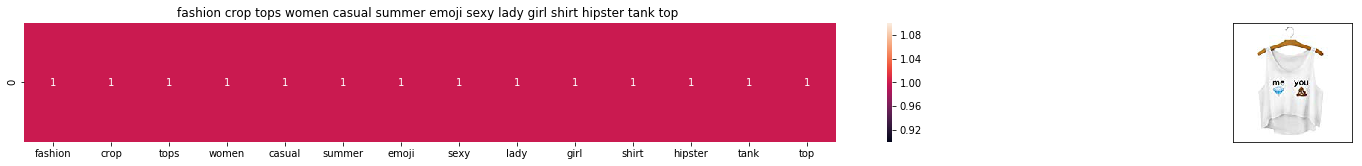

ASIN : B010V3B44G
Brand: Doxi Supermall
Title: fashion crop tops women casual summer emoji sexy lady girl shirt hipster tank top 
Euclidean similarity with the query image : 0.0


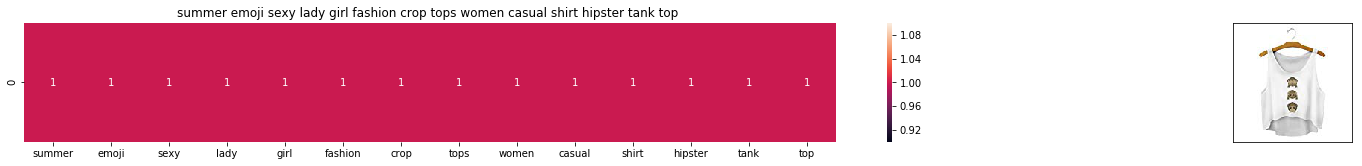

ASIN : B010V3BDII
Brand: Doxi Supermall
Title: summer emoji sexy lady girl fashion crop tops women casual shirt hipster tank top 
Euclidean similarity with the query image : 0.0


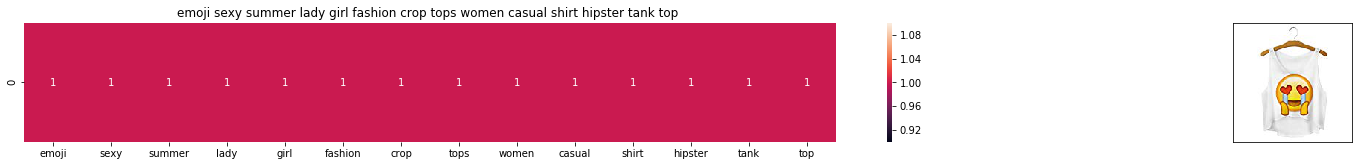

ASIN : B010V3BLWQ
Brand: Doxi Supermall
Title: emoji sexy summer lady girl fashion crop tops women casual shirt hipster tank top 
Euclidean similarity with the query image : 0.0


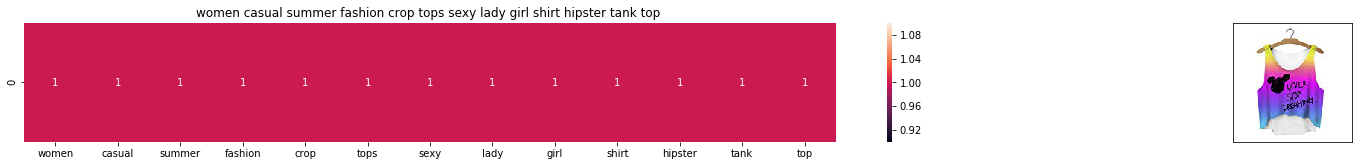

ASIN : B010V3AYSS
Brand: Doxi Supermall
Title: women casual summer fashion crop tops sexy lady girl shirt hipster tank top 
Euclidean similarity with the query image : 1.0


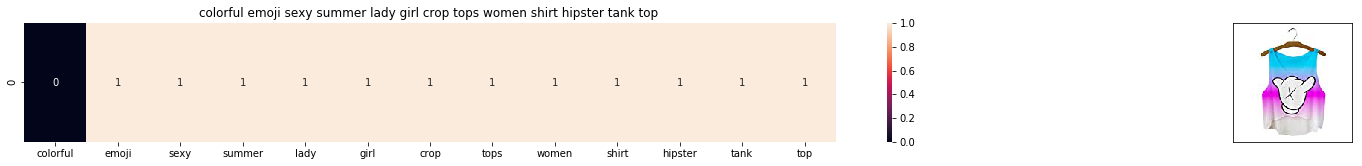

ASIN : B010V3BQZS
Brand: Doxi Supermall
Title: colorful emoji sexy summer lady girl crop tops women shirt hipster tank top 
Euclidean similarity with the query image : 1.73205080757


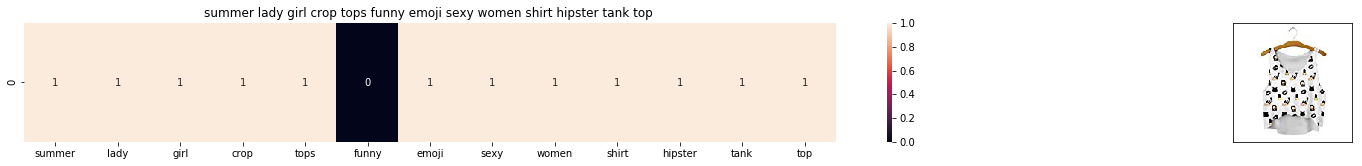

ASIN : B010V3BVMQ
Brand: Doxi Supermall
Title: summer lady girl crop tops funny emoji sexy women shirt hipster tank top 
Euclidean similarity with the query image : 1.73205080757


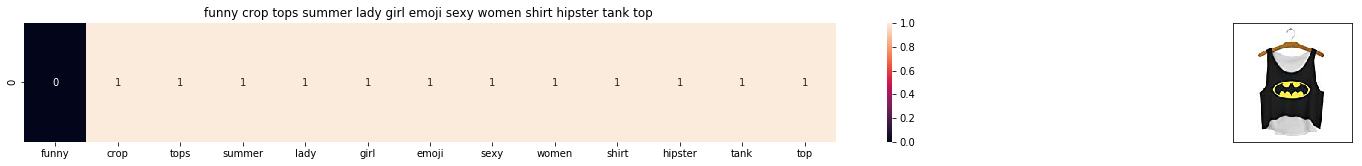

ASIN : B010V3C116
Brand: Doxi Supermall
Title: funny crop tops summer lady girl emoji sexy women shirt hipster tank top 
Euclidean similarity with the query image : 1.73205080757


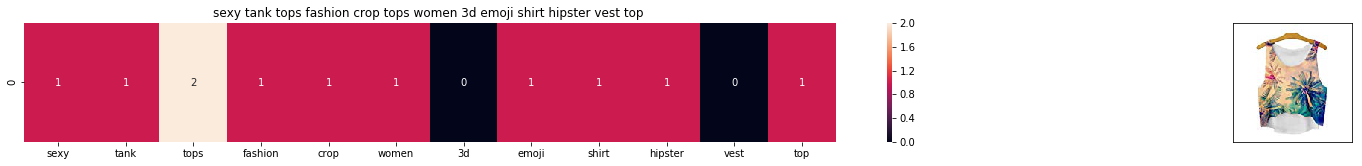

ASIN : B010V3DB9C
Brand: Doxi Supermall
Title: sexy tank tops fashion crop tops women 3d emoji shirt hipster vest top 
Euclidean similarity with the query image : 2.64575131106


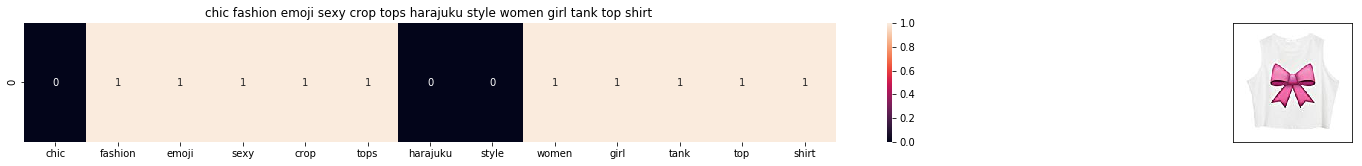

ASIN : B011RCJPR8
Brand: Chiclook Cool
Title: chic fashion emoji sexy crop tops harajuku style women girl tank top shirt 
Euclidean similarity with the query image : 2.64575131106


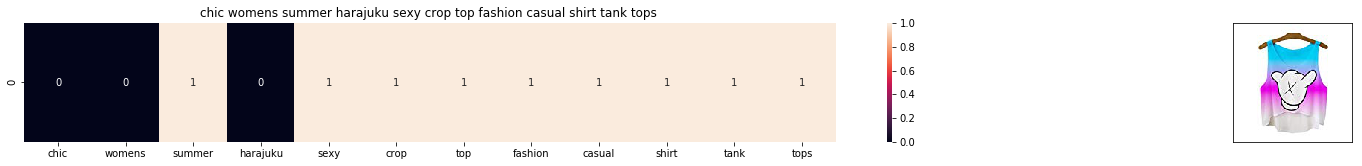

ASIN : B011RCJEMO
Brand: Chiclook Cool
Title: chic womens summer harajuku sexy crop top fashion casual shirt tank tops 
Euclidean similarity with the query image : 2.82842712475


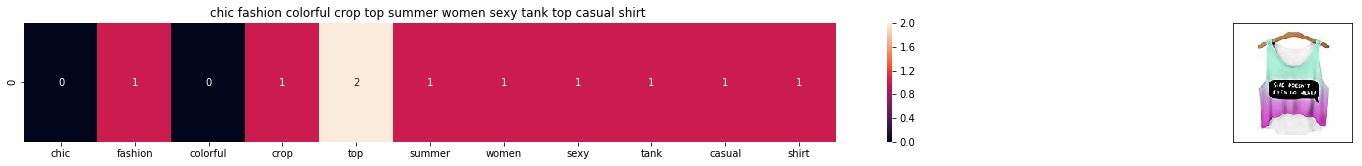

ASIN : B011RCJ6UE
Brand: Chiclook Cool
Title: chic fashion colorful crop top summer women sexy tank top casual shirt 
Euclidean similarity with the query image : 2.82842712475


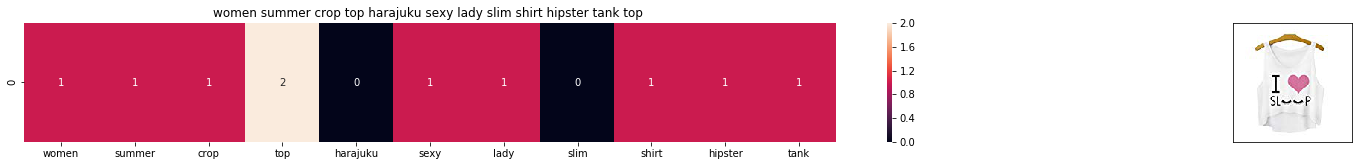

ASIN : B010V3EDEE
Brand: Doxi Supermall
Title: women summer crop top harajuku sexy lady slim shirt hipster tank top 
Euclidean similarity with the query image : 2.82842712475


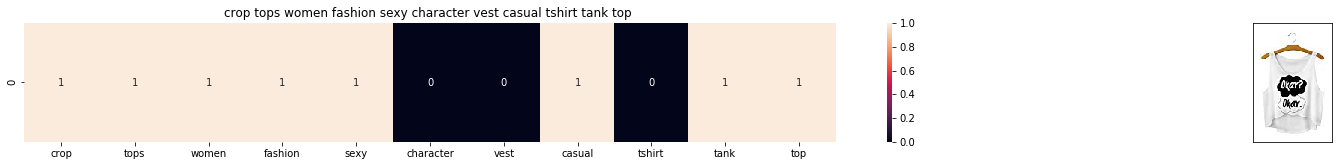

ASIN : B0107UEPVM
Brand: Mang GO
Title: crop tops women fashion sexy character vest casual tshirt tank top 
Euclidean similarity with the query image : 3.0


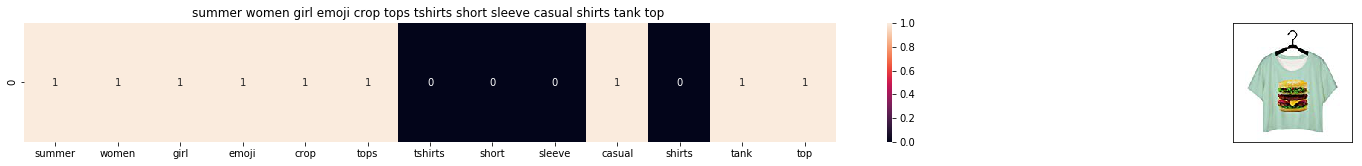

ASIN : B0124ECIU4
Brand: Doxi Supermall
Title: summer women girl emoji crop tops tshirts short sleeve casual shirts tank top 
Euclidean similarity with the query image : 3.0


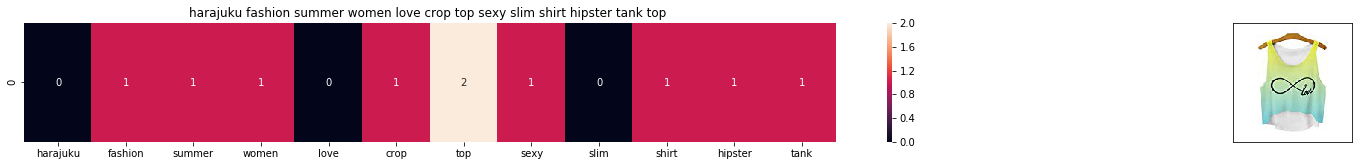

ASIN : B010V35OBU
Brand: Doxi Supermall
Title: harajuku fashion summer women love crop top sexy slim shirt hipster tank top 
Euclidean similarity with the query image : 3.0


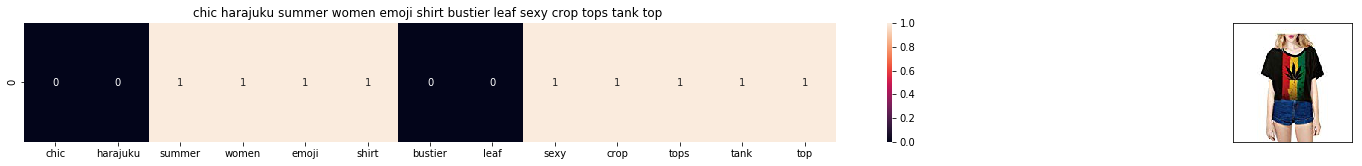

ASIN : B011UEXGH8
Brand: Chiclook Cool
Title: chic harajuku summer women emoji shirt bustier leaf sexy crop tops tank top 
Euclidean similarity with the query image : 3.0


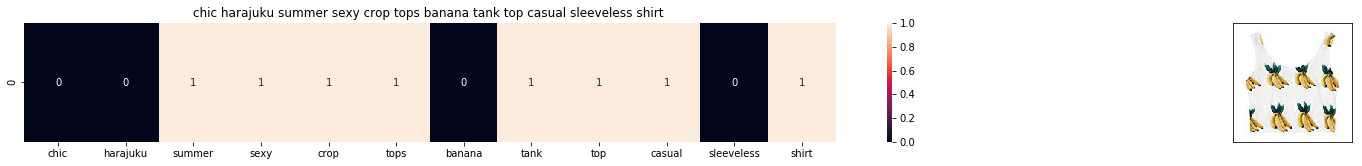

ASIN : B011RCIQBE
Brand: Chiclook Cool
Title: chic harajuku summer sexy crop tops banana tank top casual sleeveless shirt 
Euclidean similarity with the query image : 3.16227766017


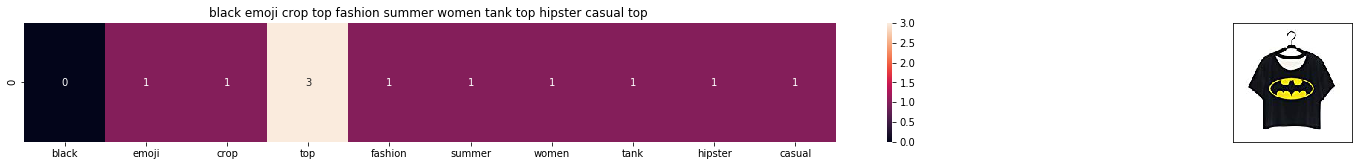

ASIN : B0124E80M4
Brand: Doxi Supermall
Title: black emoji crop top fashion summer women tank top hipster casual top 
Euclidean similarity with the query image : 3.16227766017


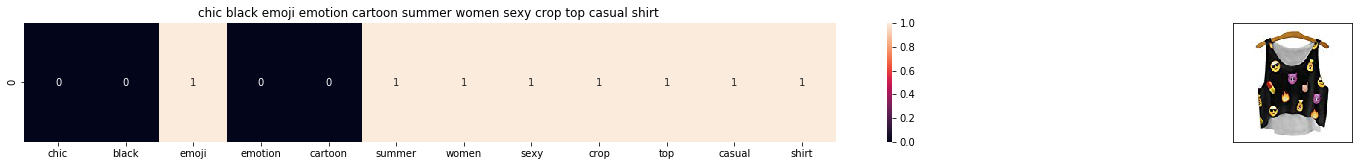

ASIN : B011RCJ4M4
Brand: Chiclook Cool
Title: chic black emoji emotion cartoon summer women sexy crop top casual shirt 
Euclidean similarity with the query image : 3.16227766017


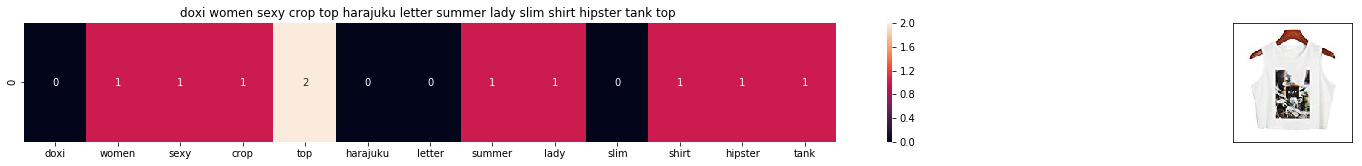

ASIN : B010V39146
Brand: Doxi Supermall
Title: doxi women sexy crop top harajuku letter summer lady slim shirt hipster tank top 
Euclidean similarity with the query image : 3.16227766017


In [44]:
def bag_of_words_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id])
    
    # np.argsort will return indices of the smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):
        # pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print ('Brand:', data['brand'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)

#call the bag-of-words model for a product to get similar products.
bag_of_words_model(12566, 20)

# TF-IDF based product similarity

In [45]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])

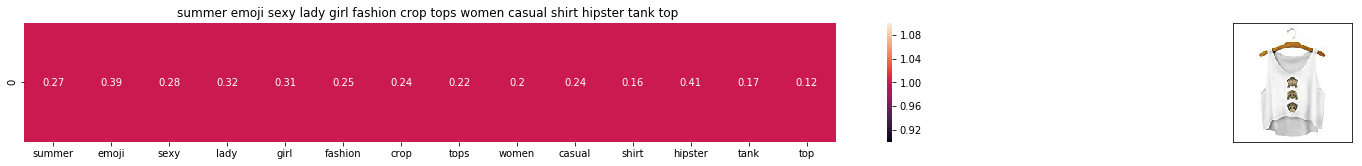

ASIN : B010V3BDII
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.0


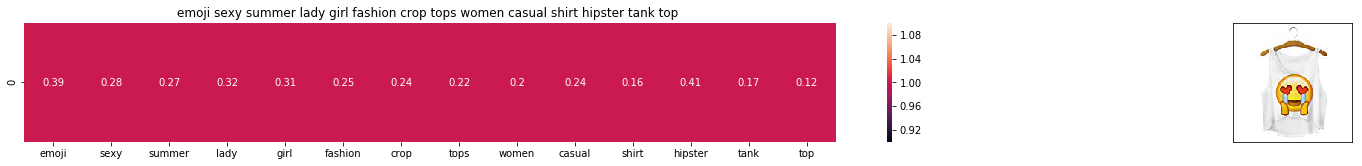

ASIN : B010V3BLWQ
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.0


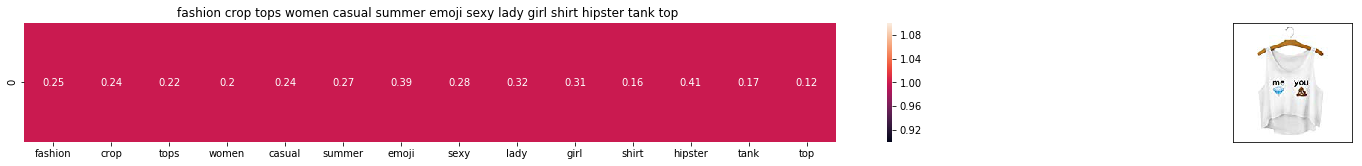

ASIN : B010V3B44G
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.0


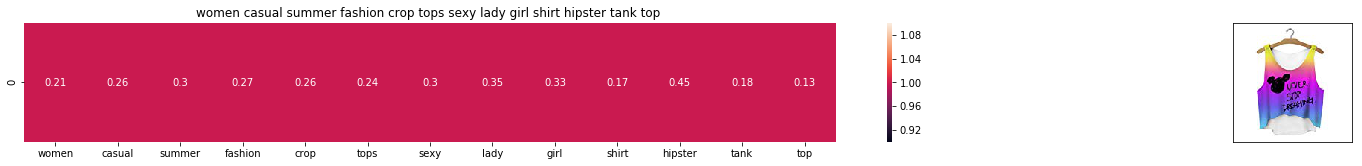

ASIN : B010V3AYSS
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.401385947502


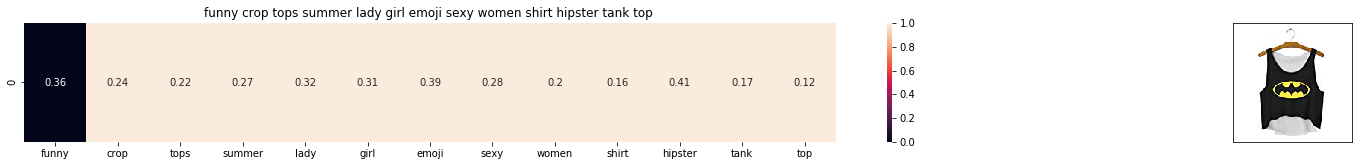

ASIN : B010V3C116
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.49544215539


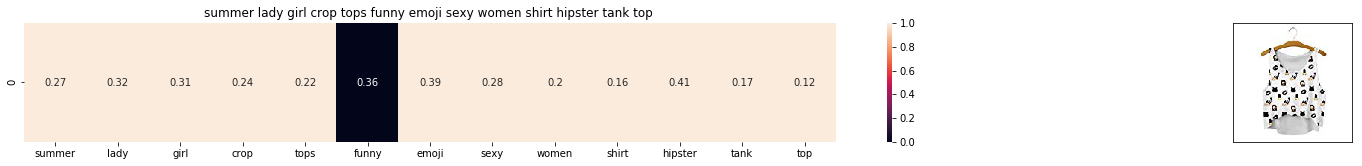

ASIN : B010V3BVMQ
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.49544215539


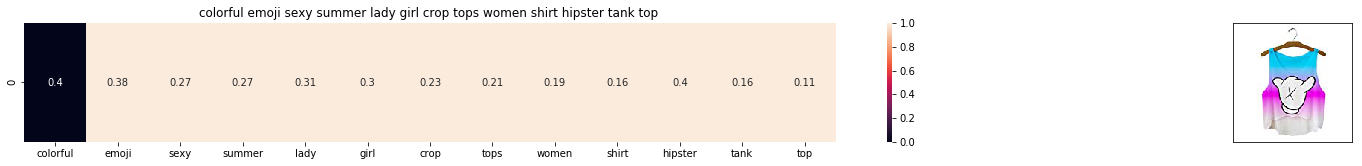

ASIN : B010V3BQZS
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.524168914029


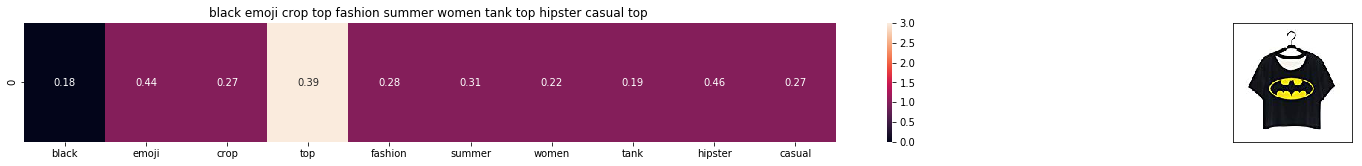

ASIN : B0124E80M4
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.684158162664


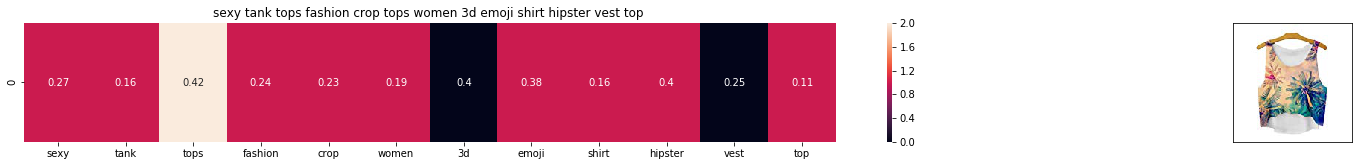

ASIN : B010V3DB9C
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.773134345511


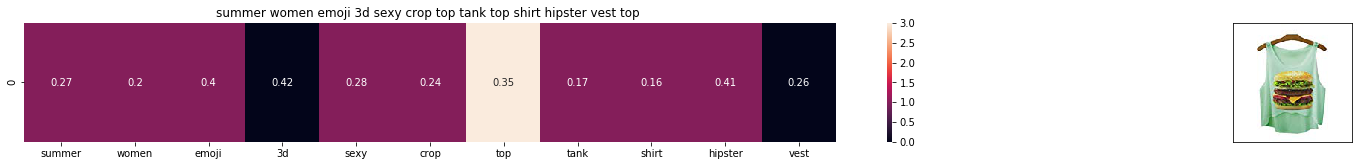

ASIN : B010V3E5EC
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.812875431399


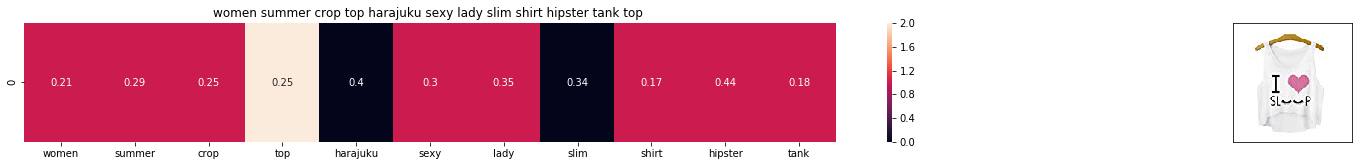

ASIN : B010V3EDEE
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.843705691286


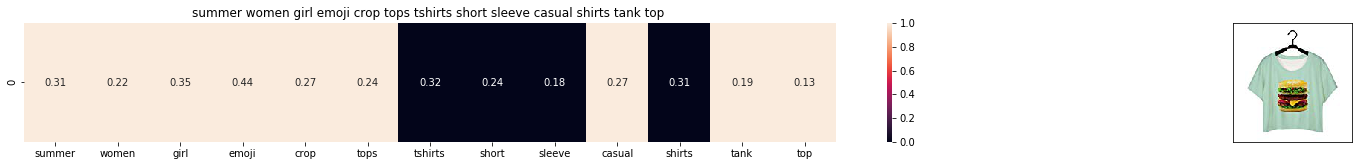

ASIN : B0124ECIU4
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.855348395425


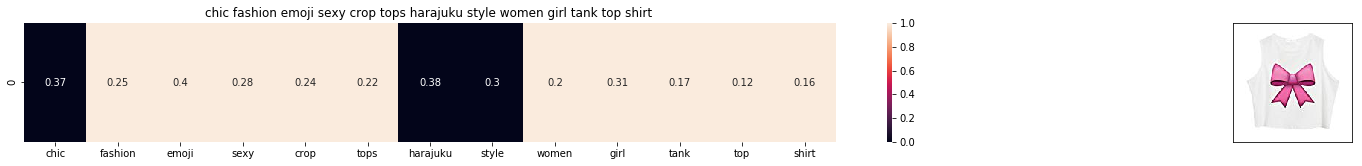

ASIN : B011RCJPR8
BRAND : Chiclook Cool
Eucliden distance from the given image : 0.882632131669


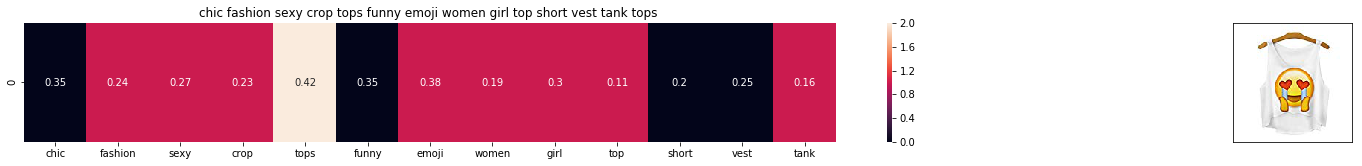

ASIN : B011RCJH58
BRAND : Chiclook Cool
Eucliden distance from the given image : 0.900401746801


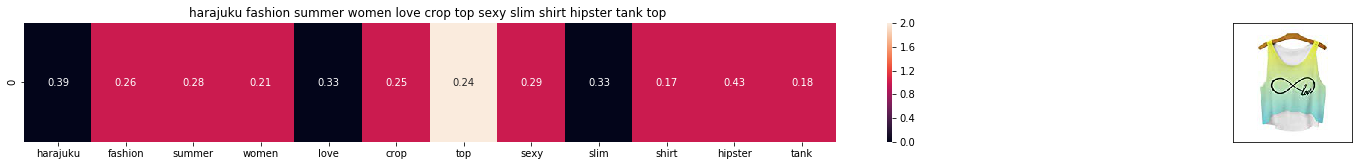

ASIN : B010V35OBU
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.917281657267


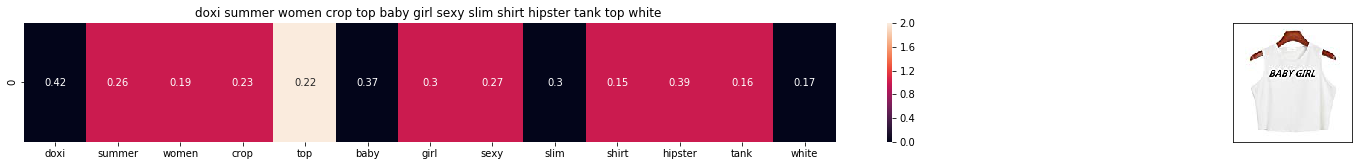

ASIN : B010V3A23U
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.930384892956


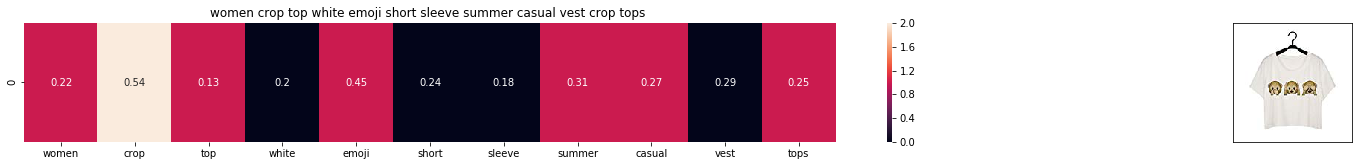

ASIN : B0124E7MHS
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.933442108098


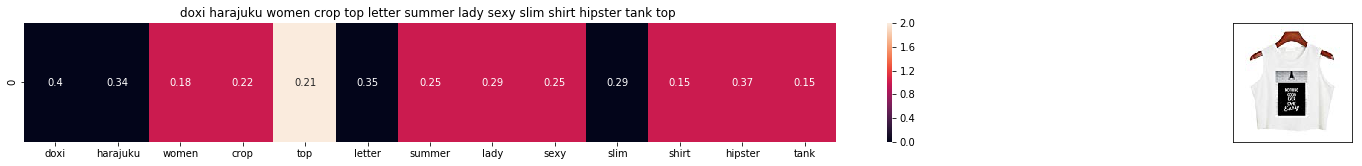

ASIN : B010V380LQ
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.95253446372


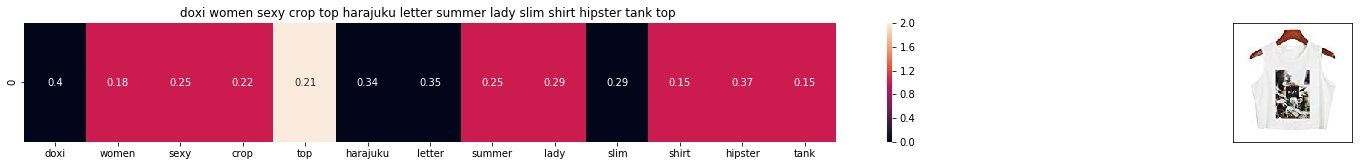

ASIN : B010V39146
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.95253446372


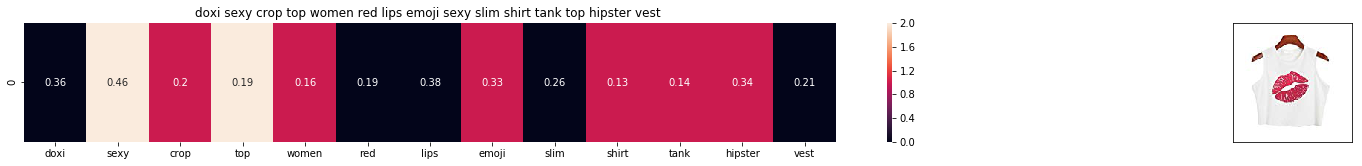

ASIN : B010TKXEHG
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.956070817415


In [46]:
def tfidf_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'tfidf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('Eucliden distance from the given image :', pdists[i])
        print('='*125)
tfidf_model(12566, 20)

#  IDF based product similarity

In [47]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])

In [48]:
def n_containing(word):
    # return the number of documents which had the given word
    return sum(1 for blob in data['title'] if word in blob.split())

def idf(word):
    # idf = log(#number of docs / #number of docs which had the given word)
    return math.log(data.shape[0] / (n_containing(word)))

In [49]:
idf_title_features  = idf_title_features.astype(np.float)

for i in idf_title_vectorizer.vocabulary_.keys():
    # for every word in whole corpus we will find its idf value
    idf_val = idf(i)
    
    # to calculate idf_title_features we need to replace the count values with the idf values of the word
    # idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0] will return all documents in which the word i present
    for j in idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:
        
        # we replace the count values of word i in document j with  idf_value of word i 
        # idf_title_features[doc_id, index_of_word_in_courpus] = idf value of word
        idf_title_features[j,idf_title_vectorizer.vocabulary_[i]] = idf_val

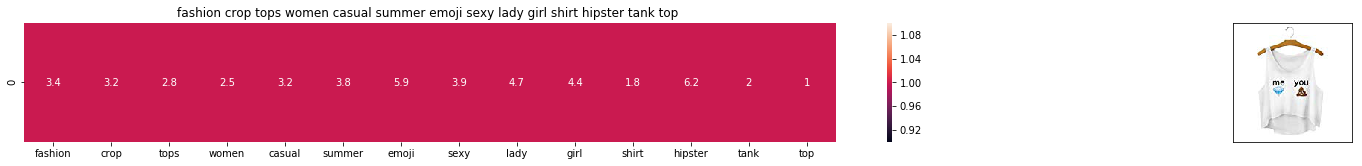

ASIN : B010V3B44G
Brand : Doxi Supermall
euclidean distance from the given image : 0.0


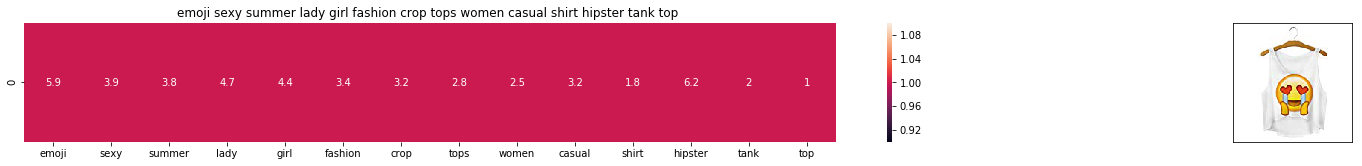

ASIN : B010V3BLWQ
Brand : Doxi Supermall
euclidean distance from the given image : 0.0


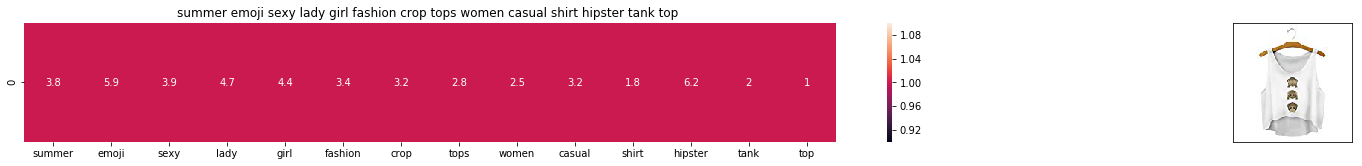

ASIN : B010V3BDII
Brand : Doxi Supermall
euclidean distance from the given image : 0.0


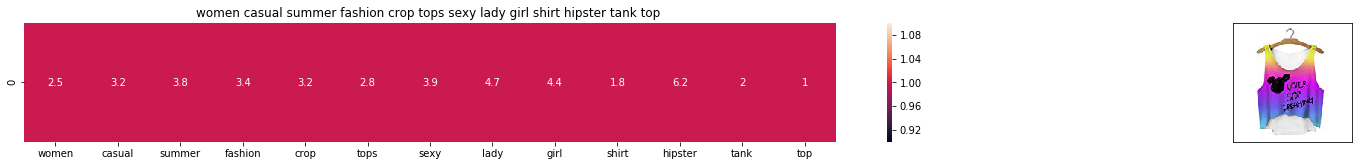

ASIN : B010V3AYSS
Brand : Doxi Supermall
euclidean distance from the given image : 5.92297885218


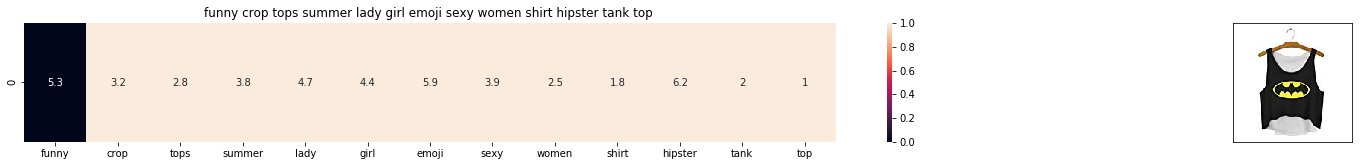

ASIN : B010V3C116
Brand : Doxi Supermall
euclidean distance from the given image : 7.0372721853


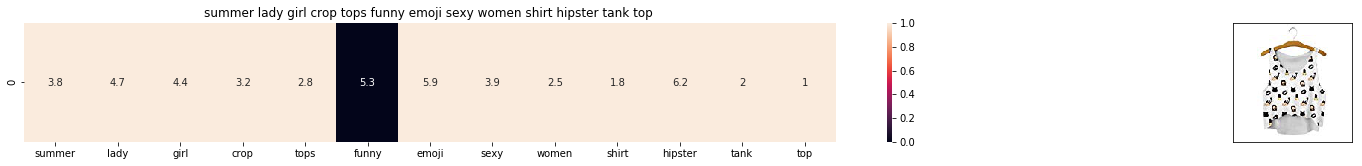

ASIN : B010V3BVMQ
Brand : Doxi Supermall
euclidean distance from the given image : 7.0372721853


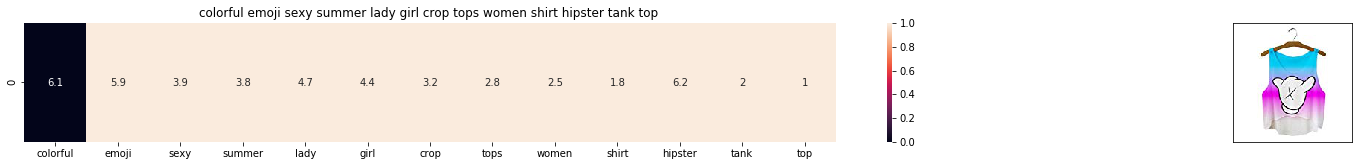

ASIN : B010V3BQZS
Brand : Doxi Supermall
euclidean distance from the given image : 7.66793954709


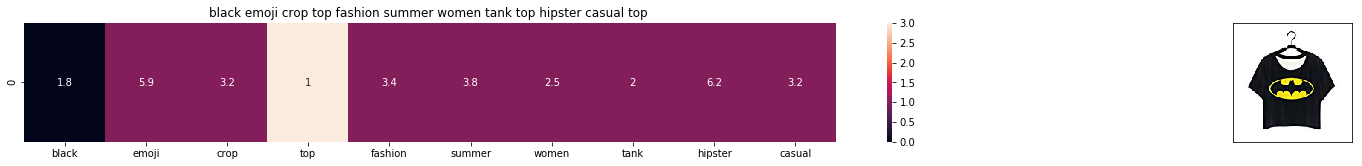

ASIN : B0124E80M4
Brand : Doxi Supermall
euclidean distance from the given image : 8.39863603811


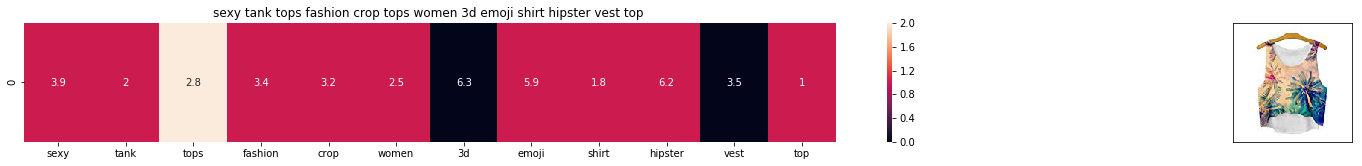

ASIN : B010V3DB9C
Brand : Doxi Supermall
euclidean distance from the given image : 10.8350901373


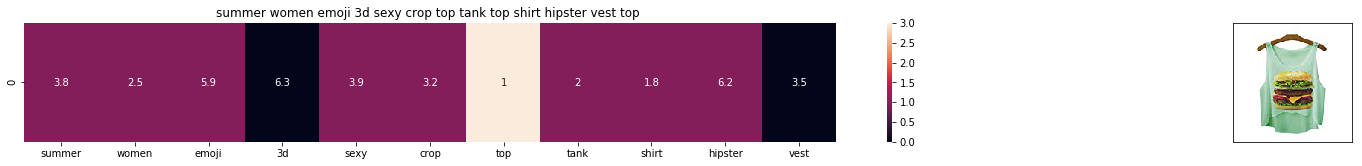

ASIN : B010V3E5EC
Brand : Doxi Supermall
euclidean distance from the given image : 11.0605301755


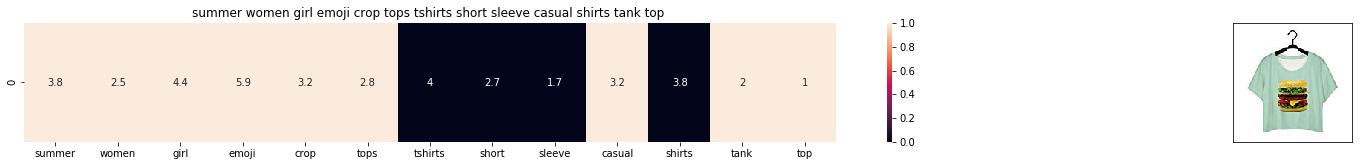

ASIN : B0124ECIU4
Brand : Doxi Supermall
euclidean distance from the given image : 11.4560177245


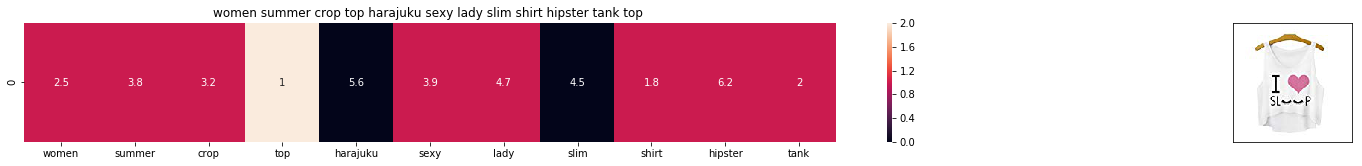

ASIN : B010V3EDEE
Brand : Doxi Supermall
euclidean distance from the given image : 11.6352659901


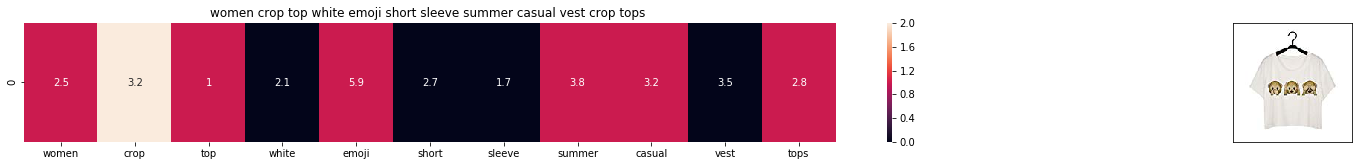

ASIN : B0124E7MHS
Brand : Doxi Supermall
euclidean distance from the given image : 11.8448342838


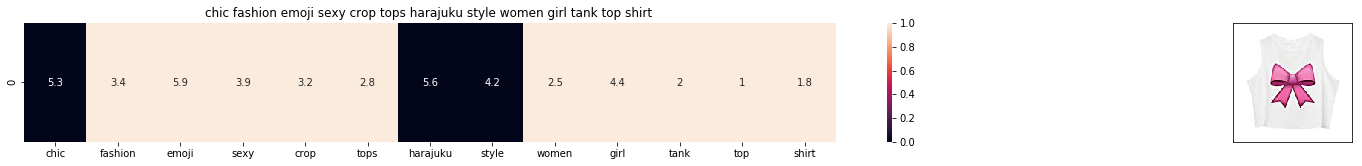

ASIN : B011RCJPR8
Brand : Chiclook Cool
euclidean distance from the given image : 12.7606928102


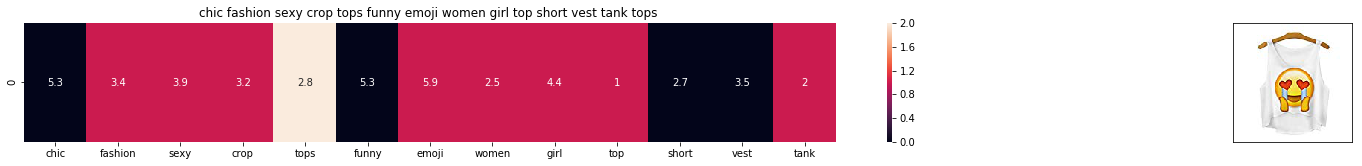

ASIN : B011RCJH58
Brand : Chiclook Cool
euclidean distance from the given image : 12.8291285046


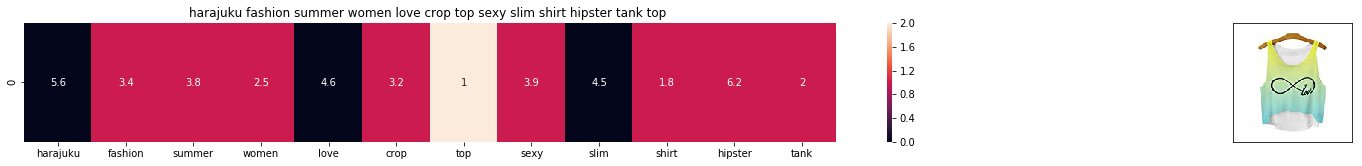

ASIN : B010V35OBU
Brand : Doxi Supermall
euclidean distance from the given image : 12.921806943


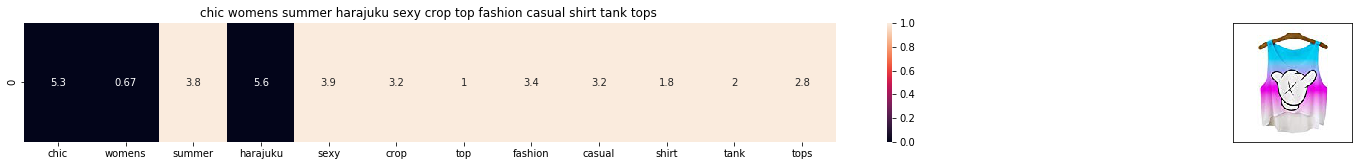

ASIN : B011RCJEMO
Brand : Chiclook Cool
euclidean distance from the given image : 13.4745557361


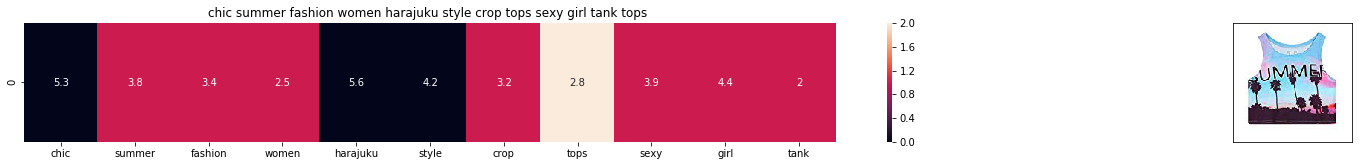

ASIN : B011OU51US
Brand : Chiclook Cool
euclidean distance from the given image : 13.7138076448


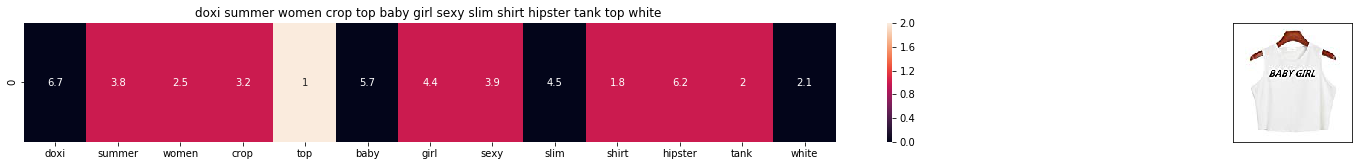

ASIN : B010V3A23U
Brand : Doxi Supermall
euclidean distance from the given image : 13.7253257415


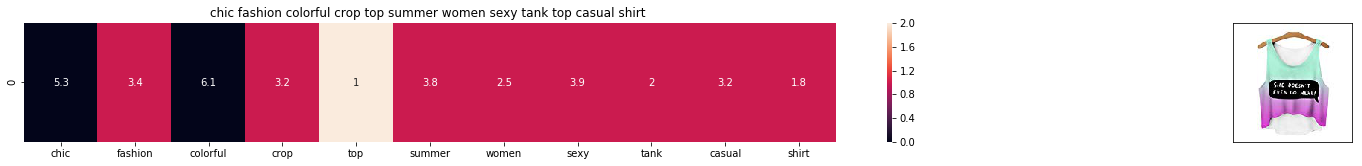

ASIN : B011RCJ6UE
Brand : Chiclook Cool
euclidean distance from the given image : 13.7467873366


In [50]:
def idf_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(idf_title_features,idf_title_features[doc_id])

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'idf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print ('euclidean distance from the given image :', pdists[i])
        print('='*125)

        
        
idf_model(12566,20)

# Text Semantics based product similarity

In [53]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [58]:
with open('word2vec_model', 'rb') as handle:
    model = pickle.load(handle)

In [59]:
def get_word_vec(sentence, doc_id, m_name):
    # sentence : title of the apparel
    # doc_id: document id in our corpus
    # m_name: model information it will take two values
        # if  m_name == 'avg', append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)
    vec = []
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in  idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[i]] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
        else:
            # if the word in our courpus is not there in the google word2vec corpus, we are just ignoring it
            vec.append(np.zeros(shape=(300,)))
    # return a numpy array of shape (#number of words in title * 300 ) 300 = len(w2v_model[word])
    # each row represents the word2vec representation of each word (weighted/avg) in given sentance 
    return  np.array(vec)

def get_distance(vec1, vec2):
    # vec1 = np.array(#number_of_words_title1 * 300), each row is a vector of length 300 corresponds to each word in give title
    # vec2 = np.array(#number_of_words_title2 * 300), each row is a vector of length 300 corresponds to each word in give title
    
    final_dist = []
    # for each vector in vec1 we caluclate the distance(euclidean) to all vectors in vec2
    for i in vec1:
        dist = []
        for j in vec2:
            # np.linalg.norm(i-j) will result the euclidean distance between vectors i, j
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
    # final_dist = np.array(#number of words in title1 * #number of words in title2)
    # final_dist[i,j] = euclidean distance between vectors i, j
    return np.array(final_dist)


def heat_map_w2v(sentence1, sentence2, url, doc_id1, doc_id2, model):
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentence1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentence2, doc_id2, model)

    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)

    
    
    # devide whole figure into 2 parts 1st part displays heatmap 2nd part displays image of apparel
    gs = gridspec.GridSpec(2, 2, width_ratios=[4,1],height_ratios=[2,1]) 
    fig = plt.figure(figsize=(15,15))
    
    ax = plt.subplot(gs[0])
    # ploting the heap map based on the pairwise distances
    ax = sns.heatmap(np.round(s1_s2_dist,4), annot=True)
    # set the x axis labels as recommended apparels title
    ax.set_xticklabels(sentence2.split())
    # set the y axis labels as input apparels title
    ax.set_yticklabels(sentence1.split())
    # set title as recommended apparels title
    ax.set_title(sentence2)
    
    ax = plt.subplot(gs[1])
    # remove all grids and axis labels for image
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    display_img(url, ax, fig)
    
    plt.show()

In [60]:
vocab = model.keys()
# this function will add the vectors of each word and returns the avg vector of given sentance
def build_avg_vec(sentence, num_features, doc_id, m_name):
    # sentace: its title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)

    featureVec = np.zeros((num_features,), dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec

#  Average Word2Vec product similarity

In [61]:
doc_id = 0
w2v_title = []
# for every title we build a avg vector representation
for i in data['title']:
    w2v_title.append(build_avg_vec(i, 300, doc_id,'avg'))
    doc_id += 1

# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title = np.array(w2v_title)

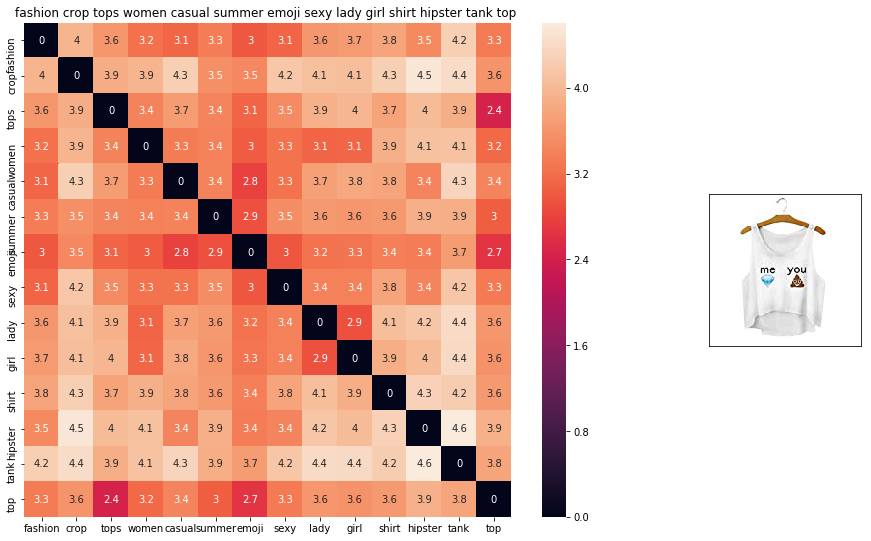

ASIN : B010V3B44G
BRAND : Doxi Supermall
euclidean distance from given input image : 0.0


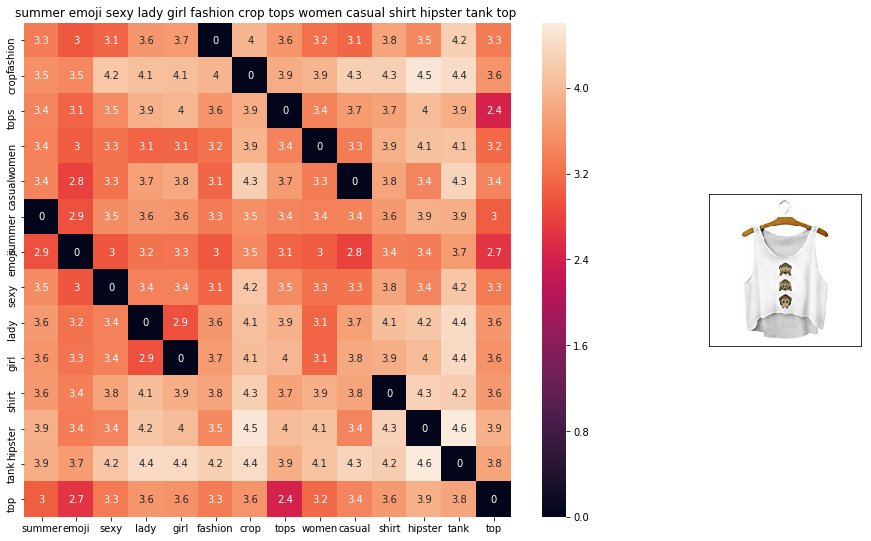

ASIN : B010V3BDII
BRAND : Doxi Supermall
euclidean distance from given input image : 0.0


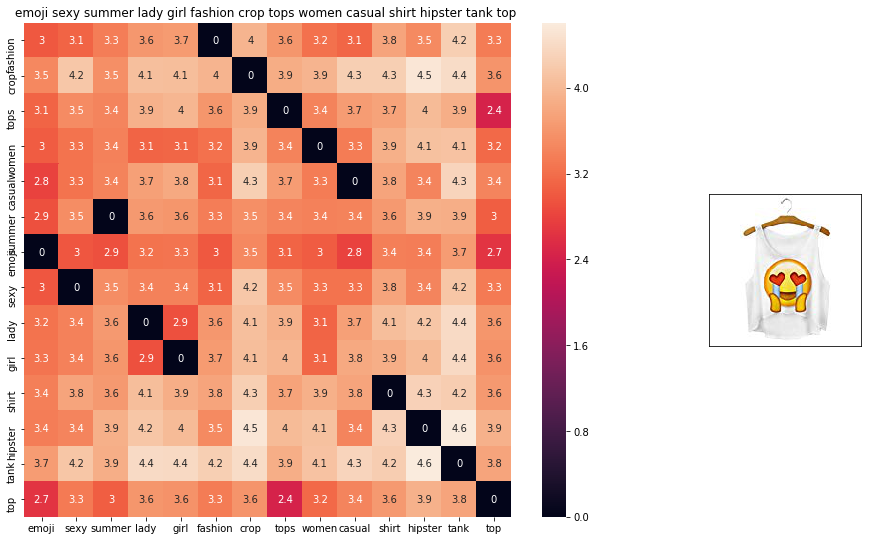

ASIN : B010V3BLWQ
BRAND : Doxi Supermall
euclidean distance from given input image : 0.0


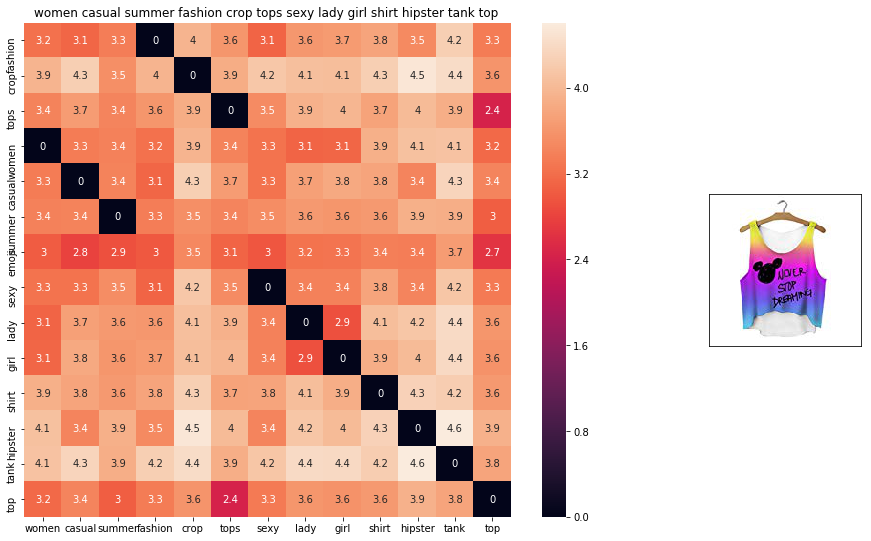

ASIN : B010V3AYSS
BRAND : Doxi Supermall
euclidean distance from given input image : 0.133682


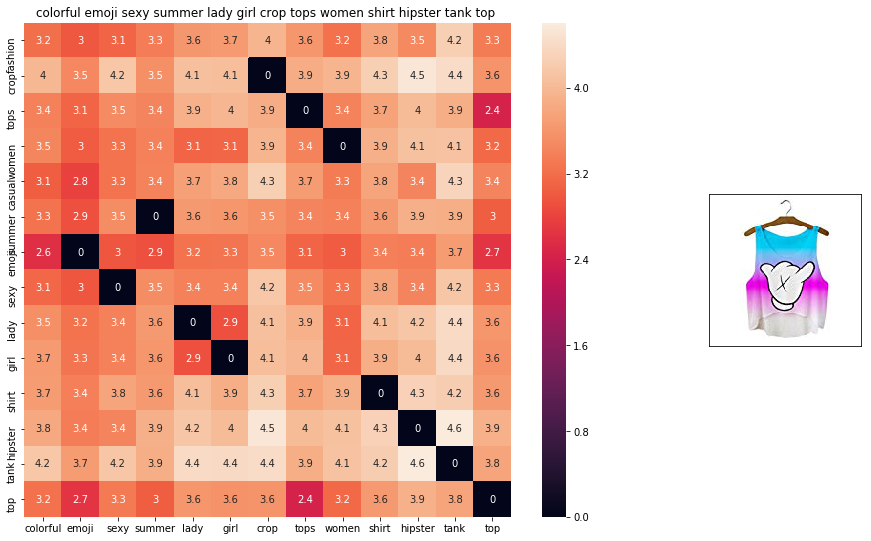

ASIN : B010V3BQZS
BRAND : Doxi Supermall
euclidean distance from given input image : 0.298377


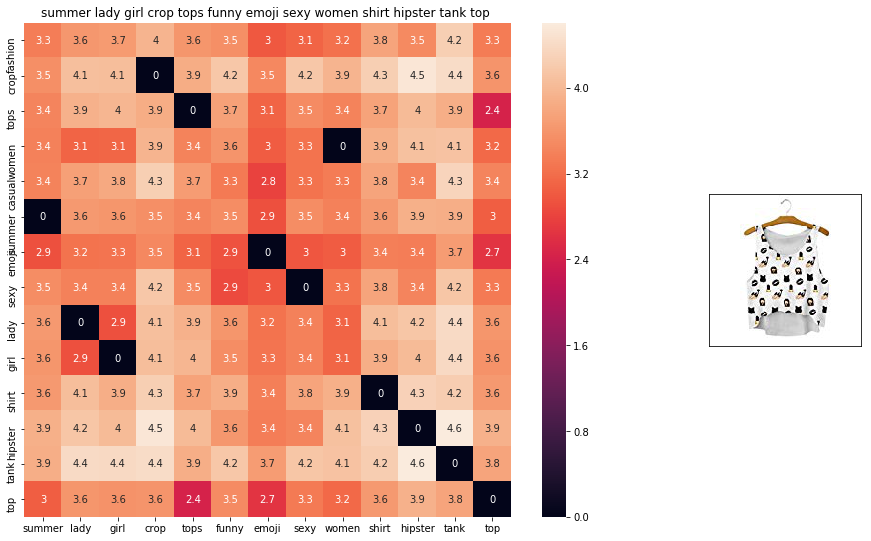

ASIN : B010V3BVMQ
BRAND : Doxi Supermall
euclidean distance from given input image : 0.327463


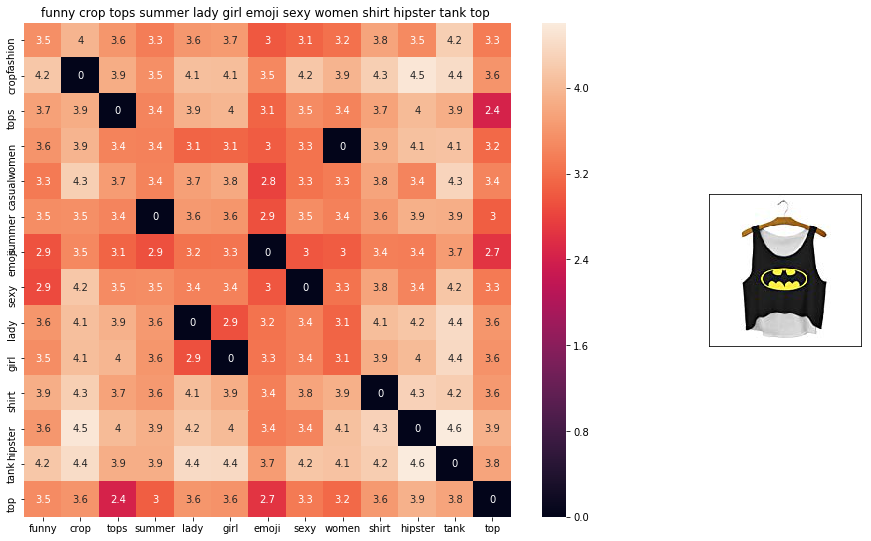

ASIN : B010V3C116
BRAND : Doxi Supermall
euclidean distance from given input image : 0.327463


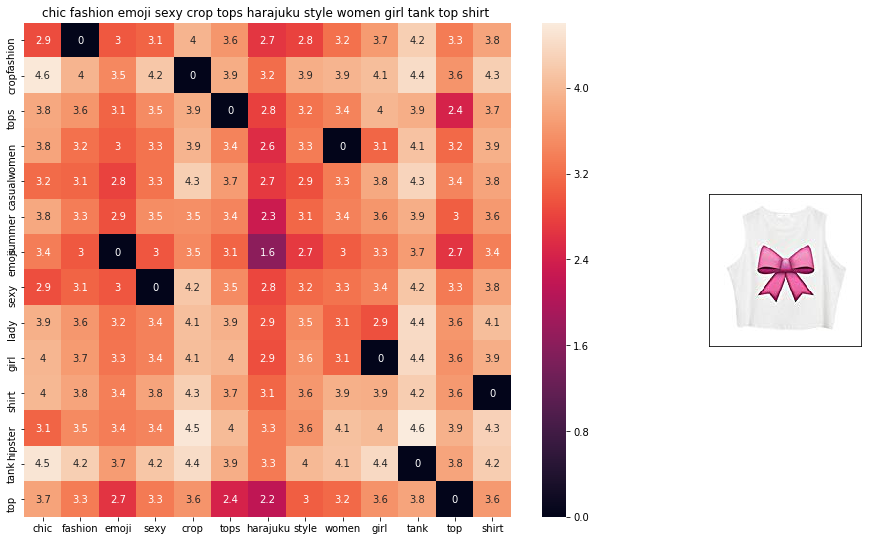

ASIN : B011RCJPR8
BRAND : Chiclook Cool
euclidean distance from given input image : 0.409759


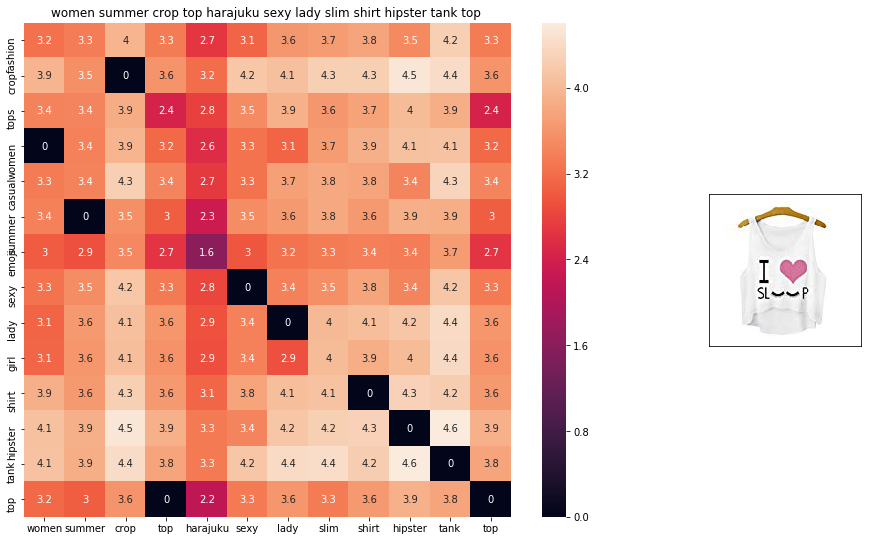

ASIN : B010V3EDEE
BRAND : Doxi Supermall
euclidean distance from given input image : 0.468066


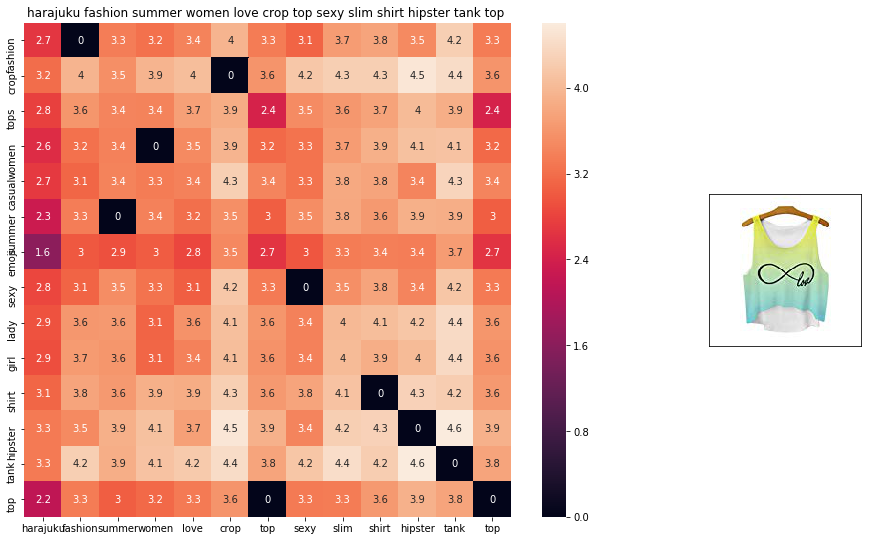

ASIN : B010V35OBU
BRAND : Doxi Supermall
euclidean distance from given input image : 0.495732


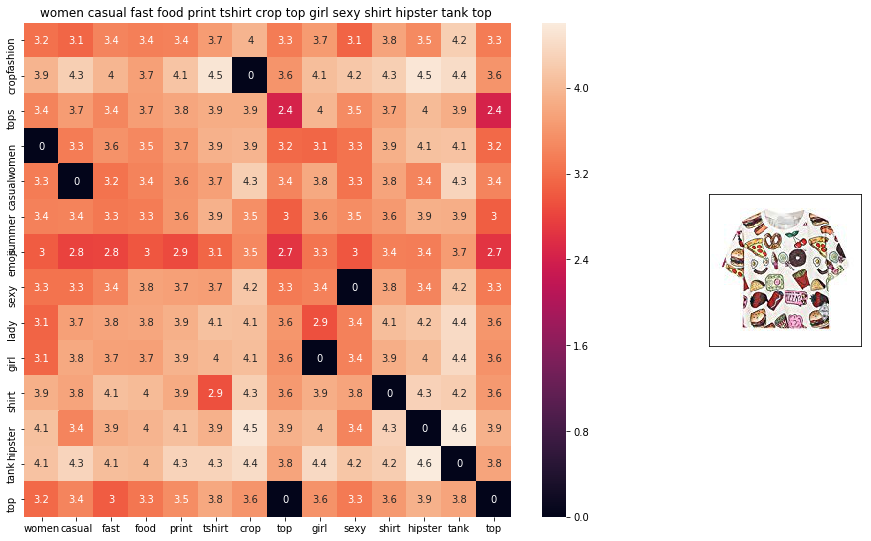

ASIN : B010V3AB5O
BRAND : Doxi Supermall
euclidean distance from given input image : 0.501076


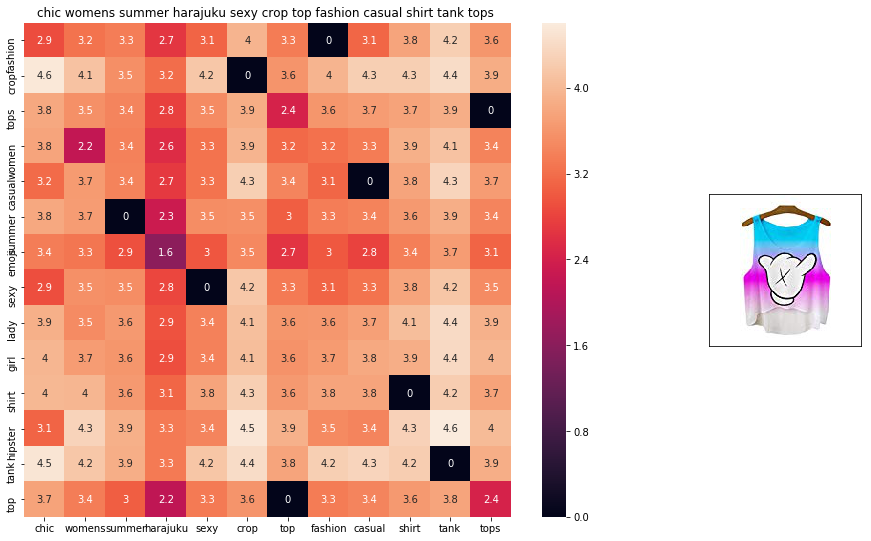

ASIN : B011RCJEMO
BRAND : Chiclook Cool
euclidean distance from given input image : 0.502728


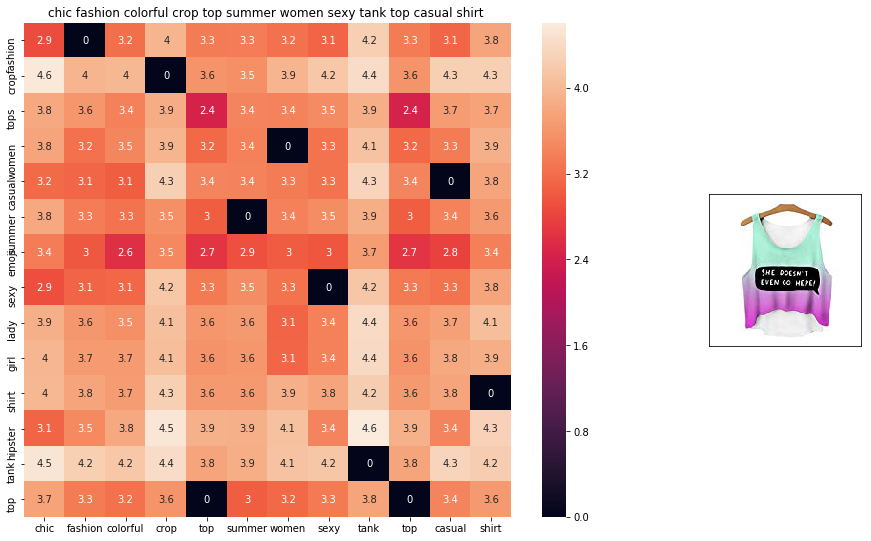

ASIN : B011RCJ6UE
BRAND : Chiclook Cool
euclidean distance from given input image : 0.507364


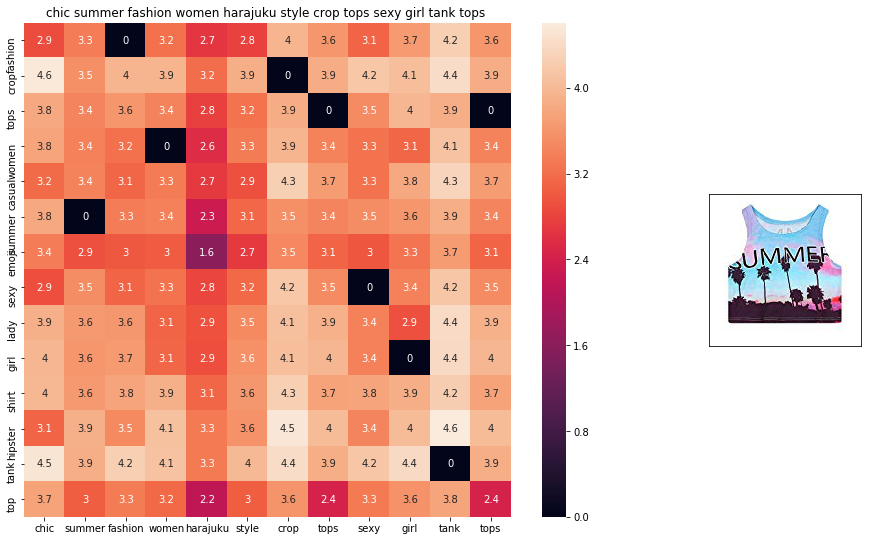

ASIN : B011OU51US
BRAND : Chiclook Cool
euclidean distance from given input image : 0.516089


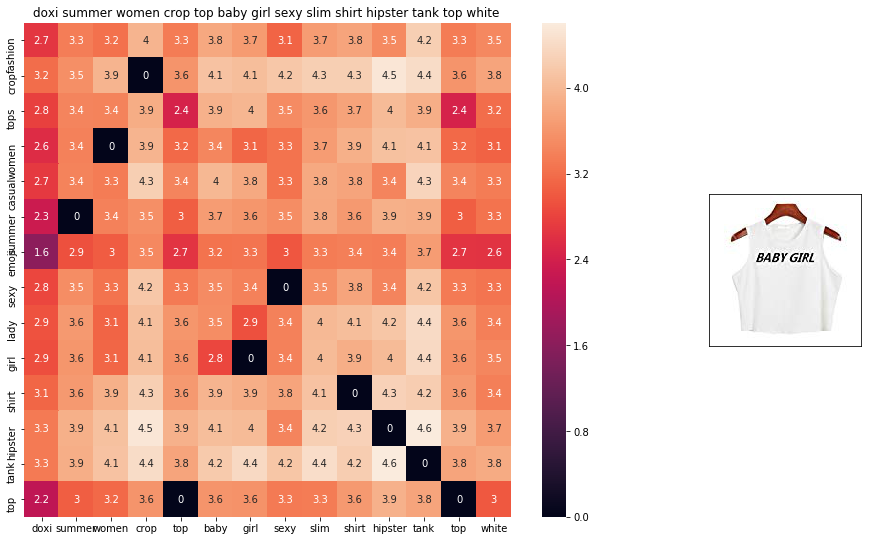

ASIN : B010V3A23U
BRAND : Doxi Supermall
euclidean distance from given input image : 0.526279


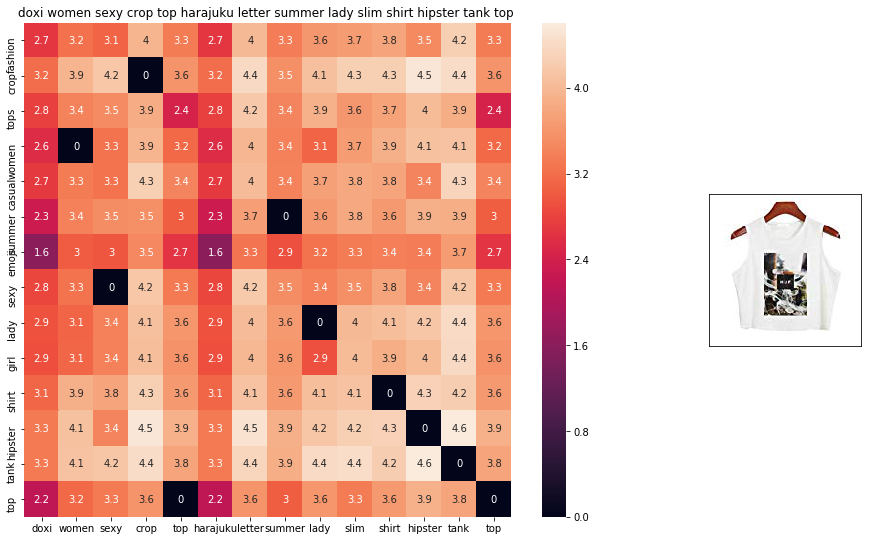

ASIN : B010V39146
BRAND : Doxi Supermall
euclidean distance from given input image : 0.527072


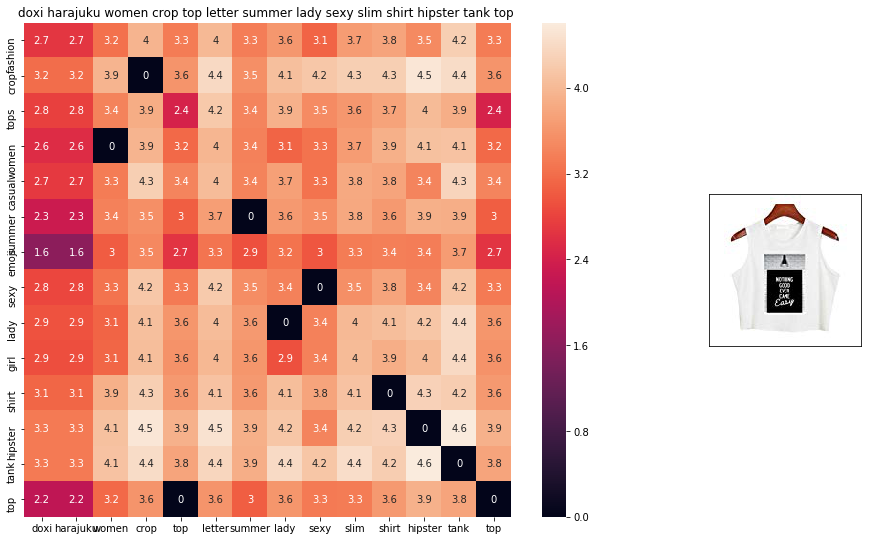

ASIN : B010V380LQ
BRAND : Doxi Supermall
euclidean distance from given input image : 0.527072


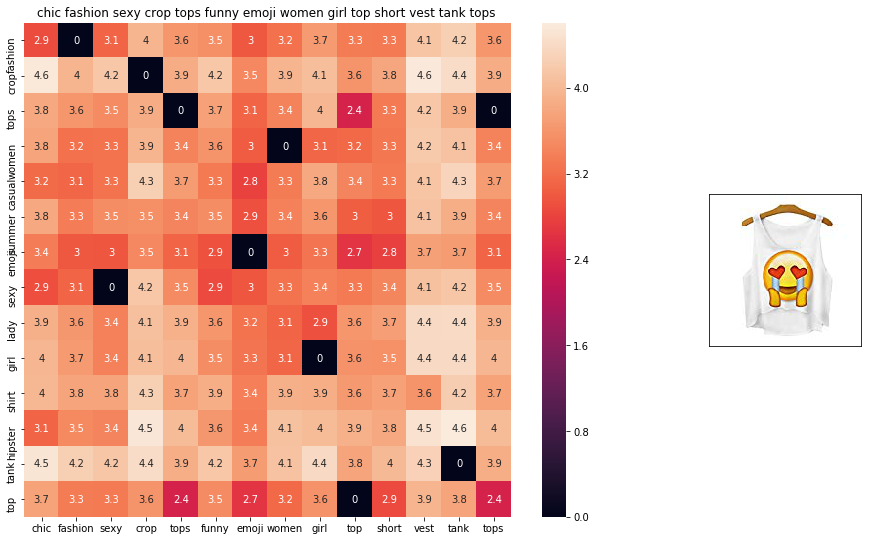

ASIN : B011RCJH58
BRAND : Chiclook Cool
euclidean distance from given input image : 0.52817


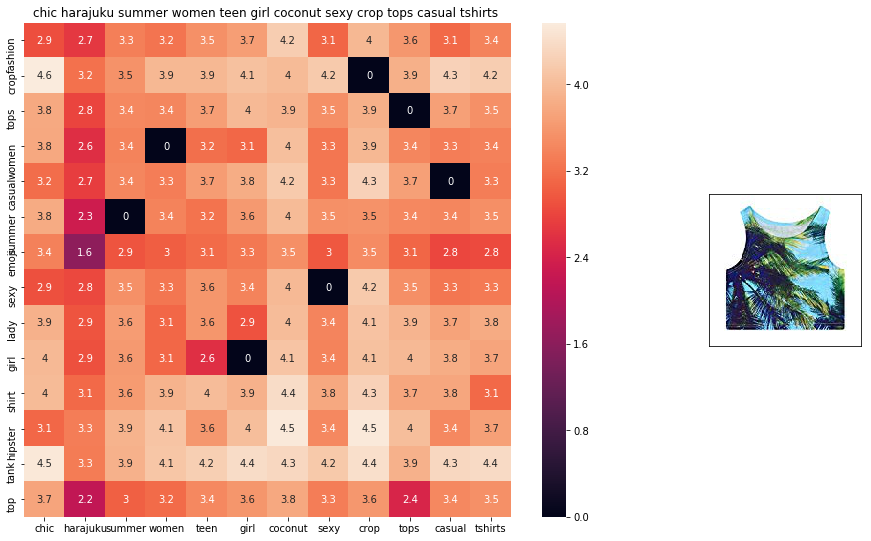

ASIN : B011OU4R08
BRAND : Chiclook Cool
euclidean distance from given input image : 0.554563


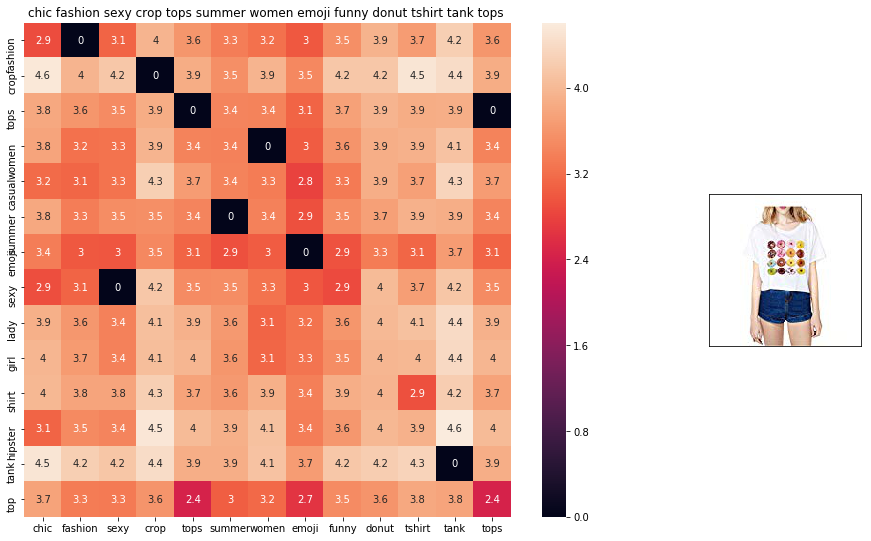

ASIN : B011UEUTQE
BRAND : Chiclook Cool
euclidean distance from given input image : 0.573492


In [62]:
def avg_w2v_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # dist(x, y) = sqrt(dot(x, x) - 2 * dot(x, y) + dot(y, y))
    pairwise_dist = pairwise_distances(w2v_title, w2v_title[doc_id].reshape(1,-1))

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heat_map_w2v(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i], 'avg')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('euclidean distance from given input image :', pdists[i])
        print('='*125)

        
avg_w2v_model(12566, 20)

# IDF weighted Word2Vec for product similarity

In [63]:
doc_id = 0
w2v_title_weight = []
# for every title we build a weighted vector representation
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1
# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title_weight = np.array(w2v_title_weight)

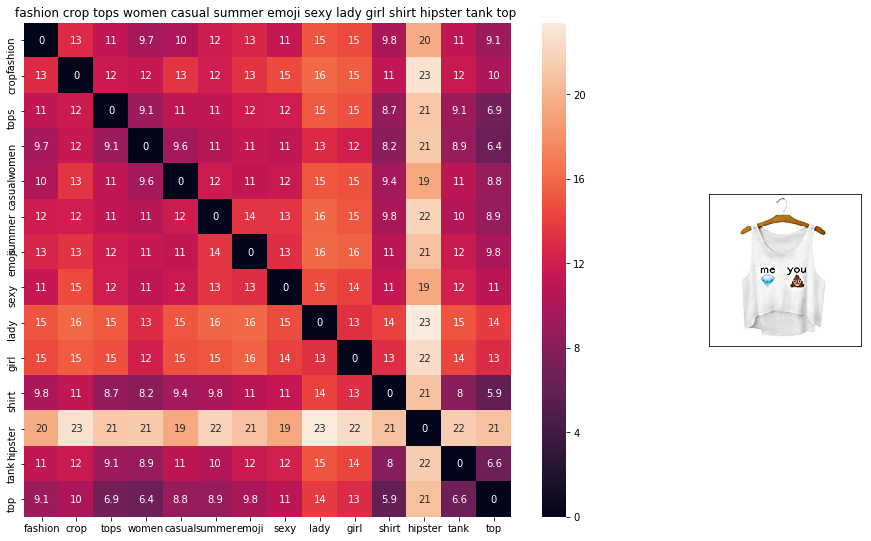

ASIN : B010V3B44G
Brand : Doxi Supermall
euclidean distance from input : 0.00195313


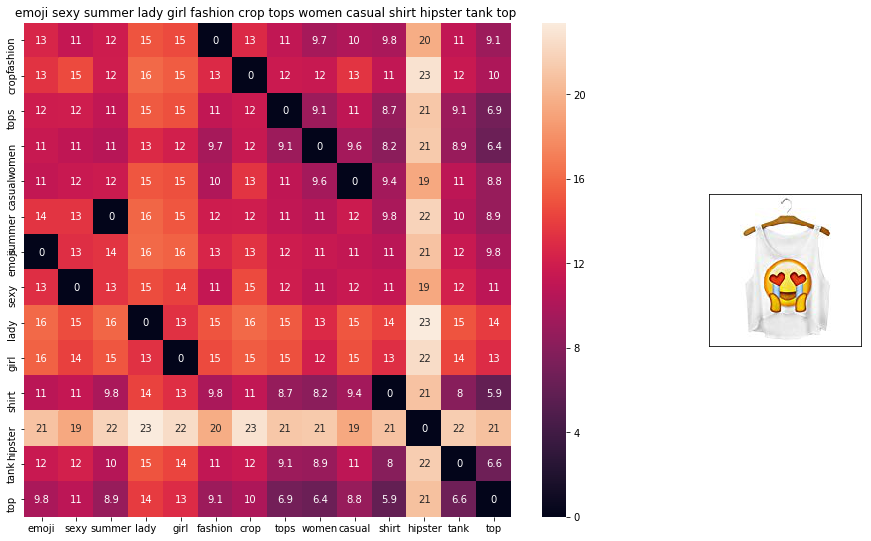

ASIN : B010V3BLWQ
Brand : Doxi Supermall
euclidean distance from input : 0.00195313


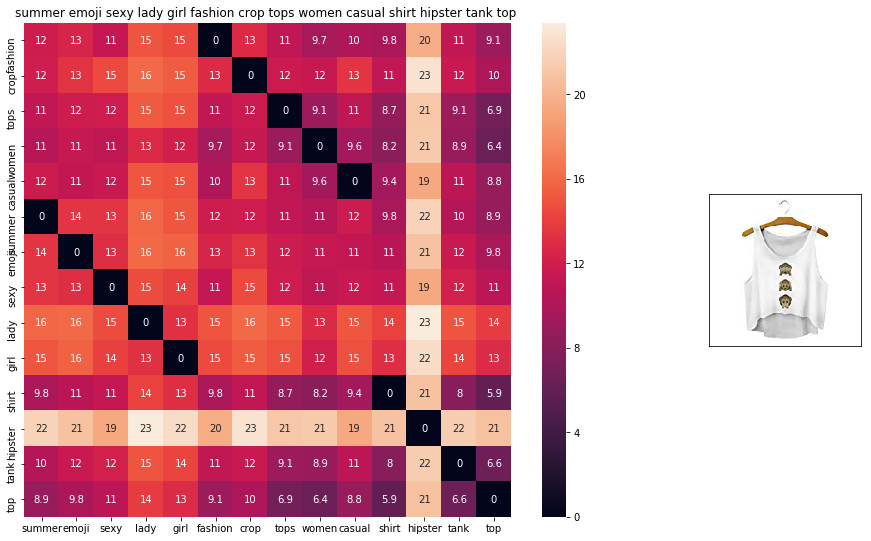

ASIN : B010V3BDII
Brand : Doxi Supermall
euclidean distance from input : 0.00195313


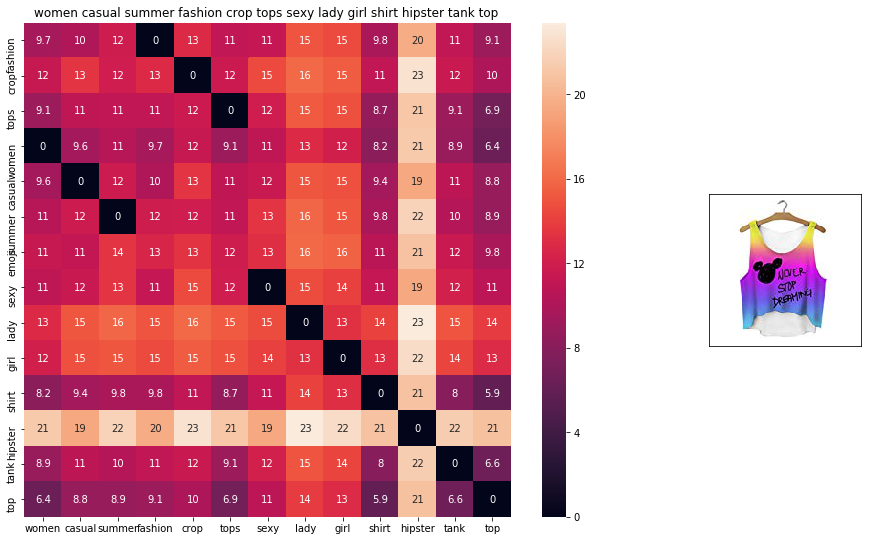

ASIN : B010V3AYSS
Brand : Doxi Supermall
euclidean distance from input : 0.696231


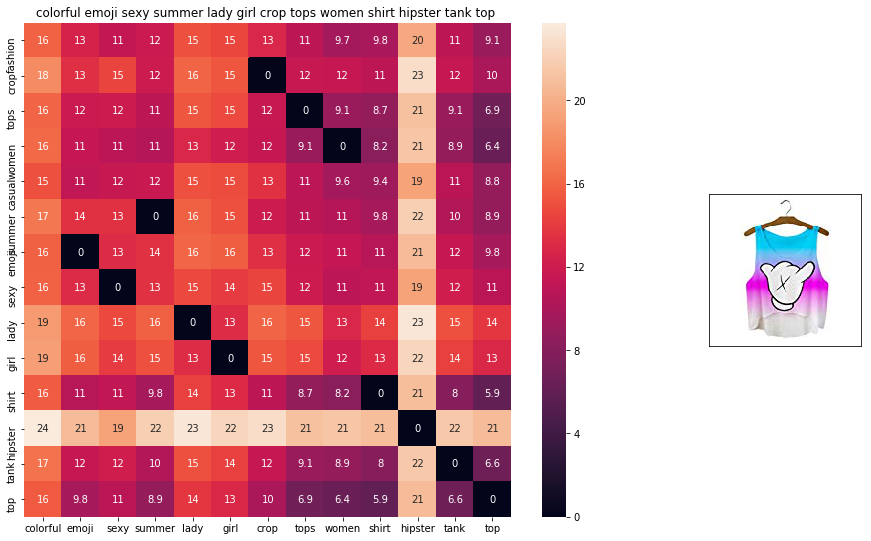

ASIN : B010V3BQZS
Brand : Doxi Supermall
euclidean distance from input : 1.28727


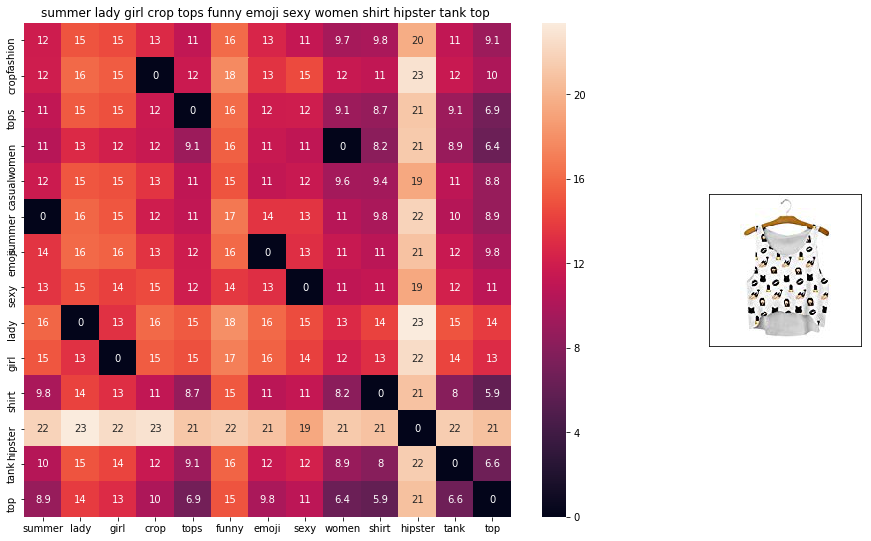

ASIN : B010V3BVMQ
Brand : Doxi Supermall
euclidean distance from input : 1.35305


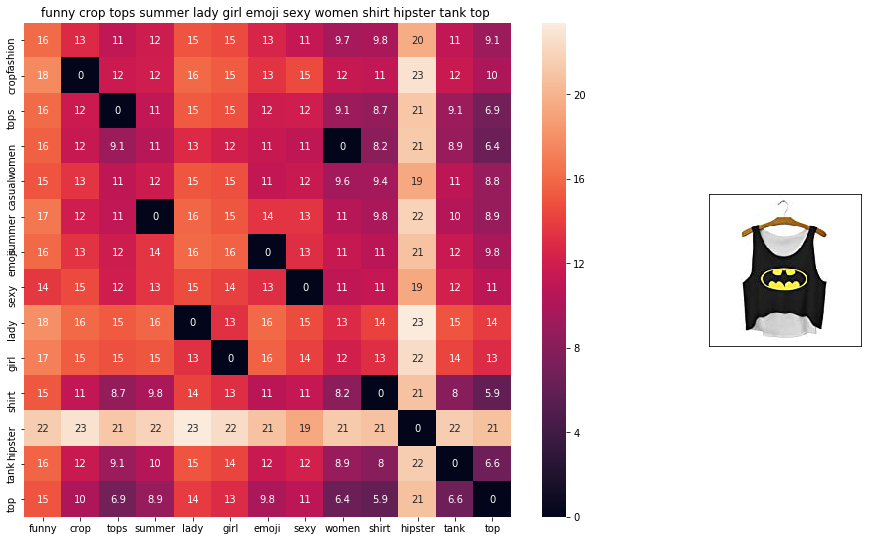

ASIN : B010V3C116
Brand : Doxi Supermall
euclidean distance from input : 1.35305


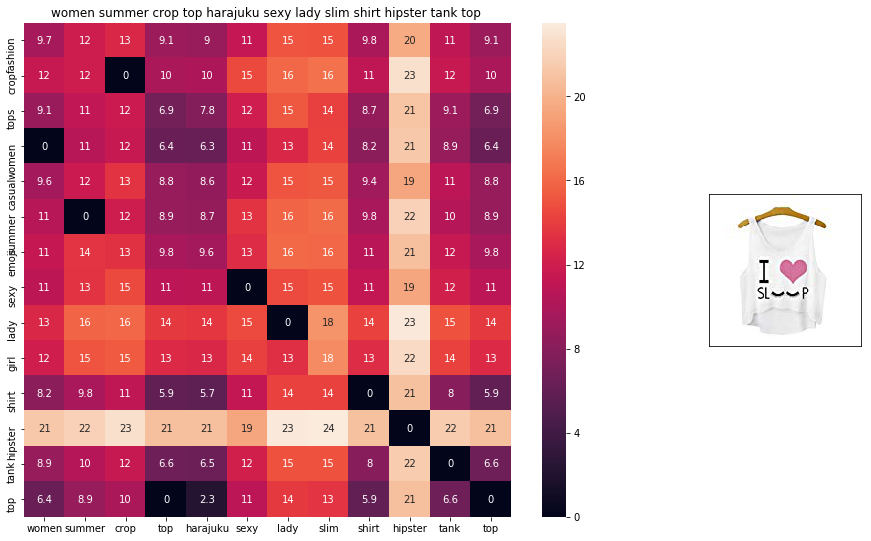

ASIN : B010V3EDEE
Brand : Doxi Supermall
euclidean distance from input : 1.74341


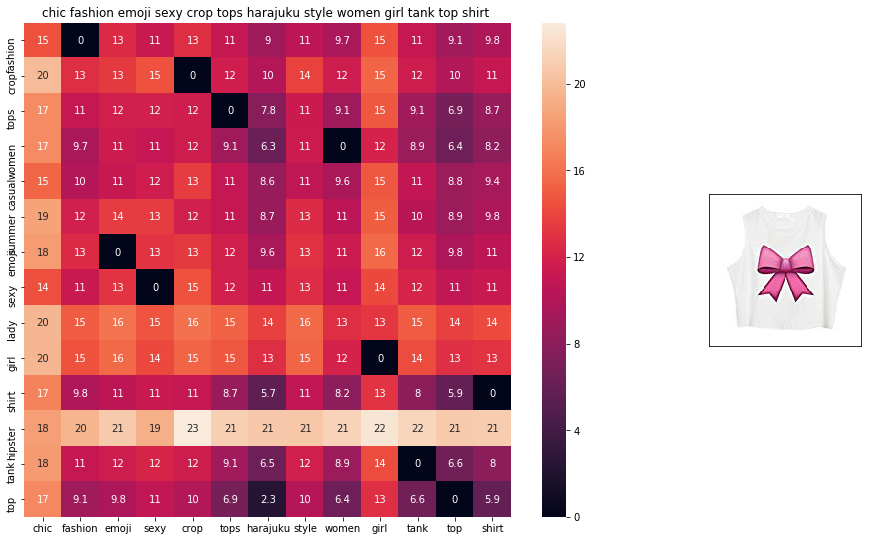

ASIN : B011RCJPR8
Brand : Chiclook Cool
euclidean distance from input : 1.93453


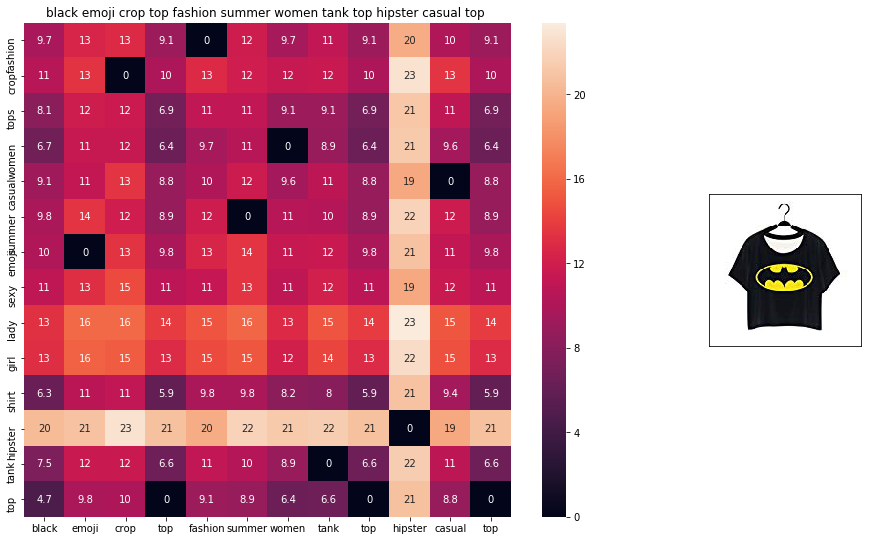

ASIN : B0124E80M4
Brand : Doxi Supermall
euclidean distance from input : 2.03214


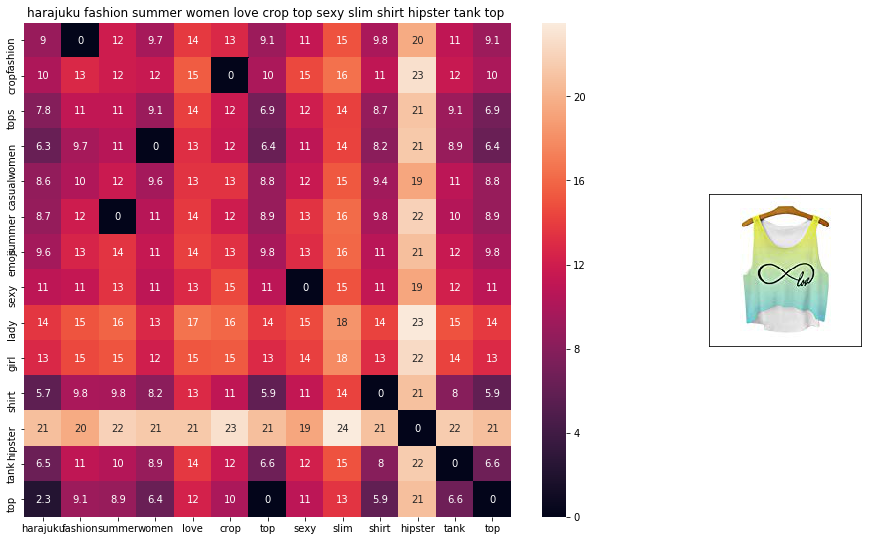

ASIN : B010V35OBU
Brand : Doxi Supermall
euclidean distance from input : 2.06319


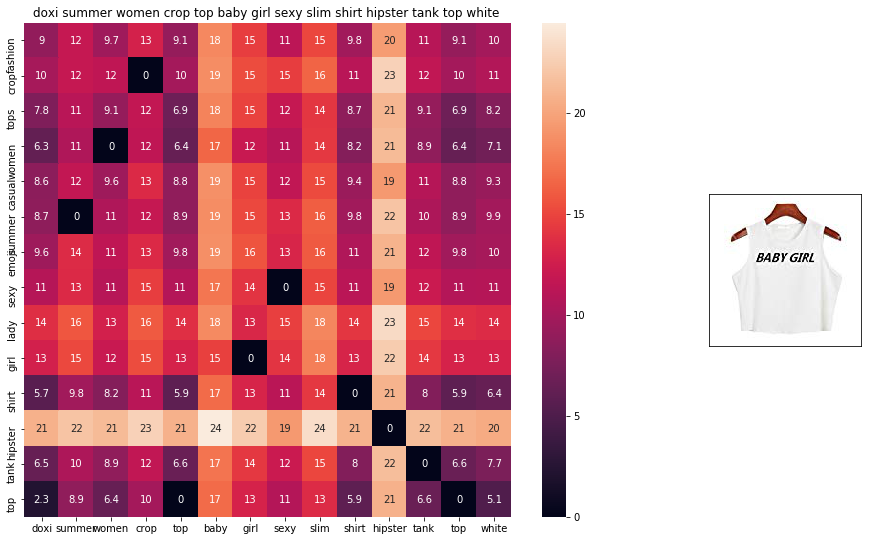

ASIN : B010V3A23U
Brand : Doxi Supermall
euclidean distance from input : 2.12437


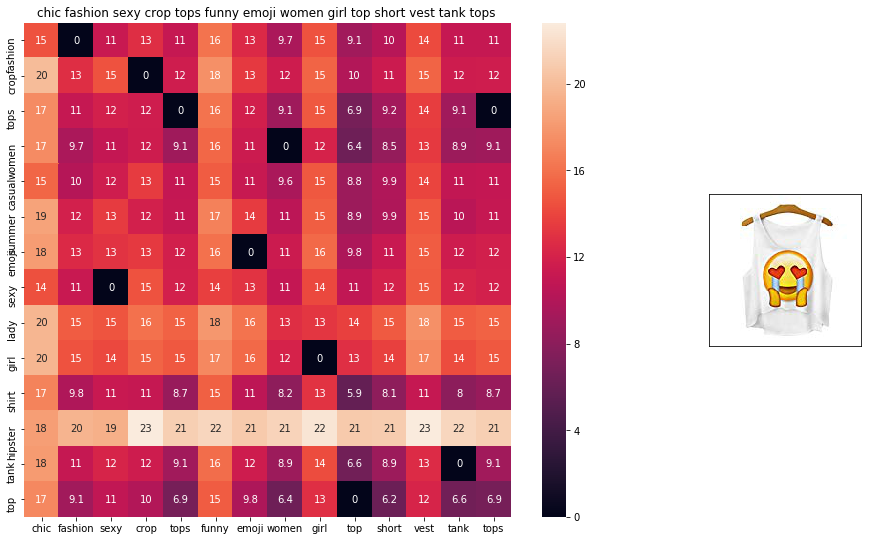

ASIN : B011RCJH58
Brand : Chiclook Cool
euclidean distance from input : 2.15071


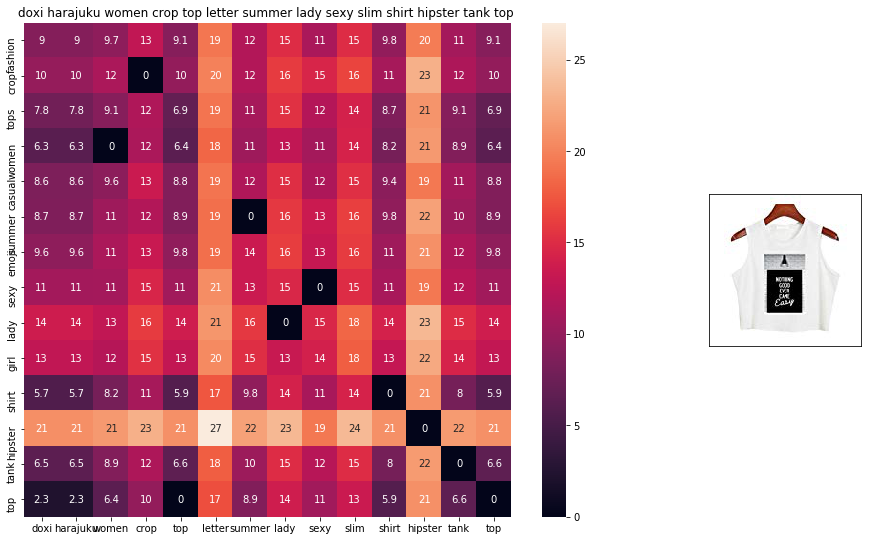

ASIN : B010V380LQ
Brand : Doxi Supermall
euclidean distance from input : 2.16749


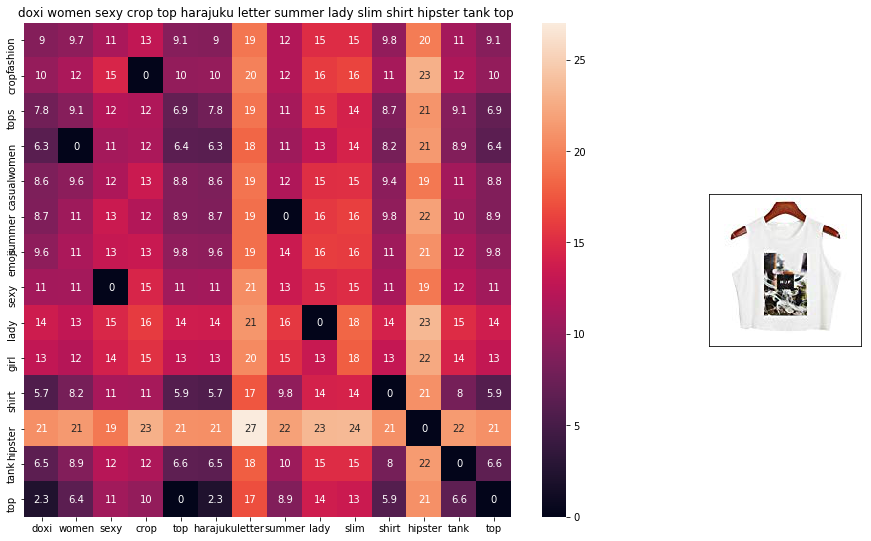

ASIN : B010V39146
Brand : Doxi Supermall
euclidean distance from input : 2.16749


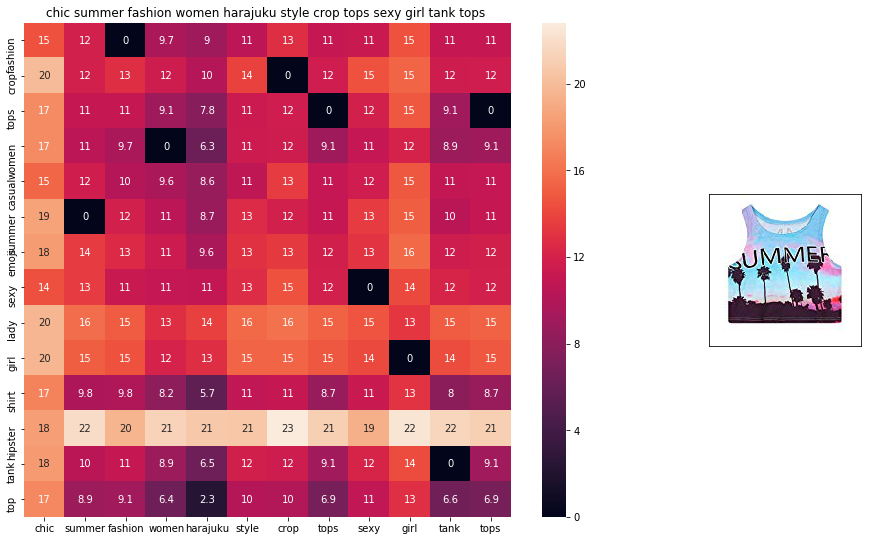

ASIN : B011OU51US
Brand : Chiclook Cool
euclidean distance from input : 2.23202


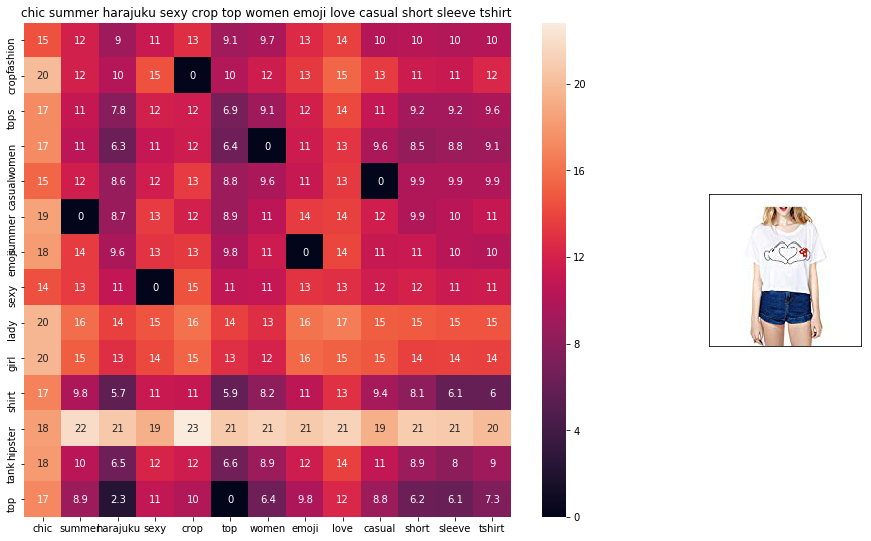

ASIN : B011UEVF4O
Brand : Chiclook Cool
euclidean distance from input : 2.31345


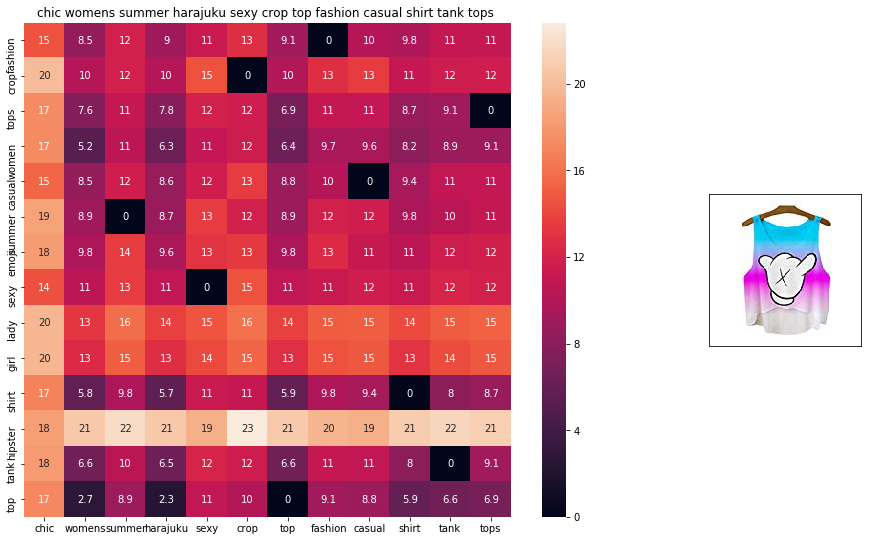

ASIN : B011RCJEMO
Brand : Chiclook Cool
euclidean distance from input : 2.33788


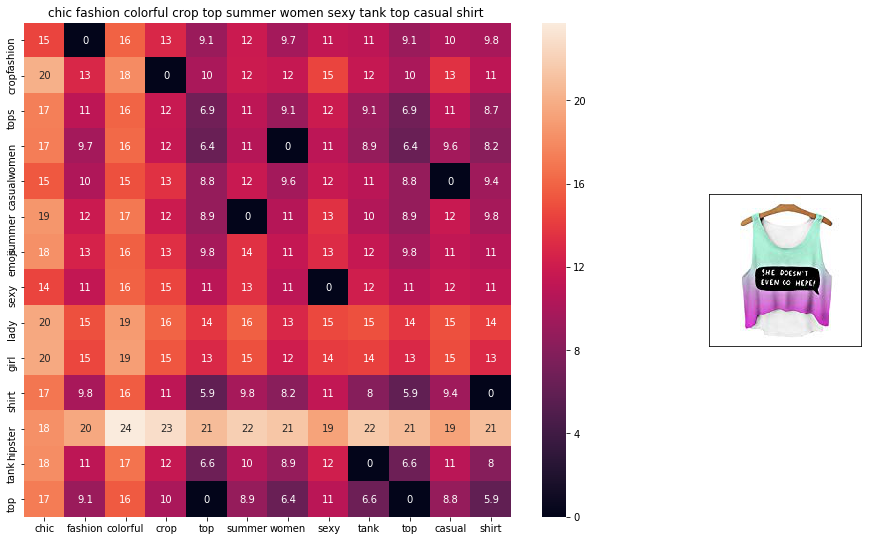

ASIN : B011RCJ6UE
Brand : Chiclook Cool
euclidean distance from input : 2.51518


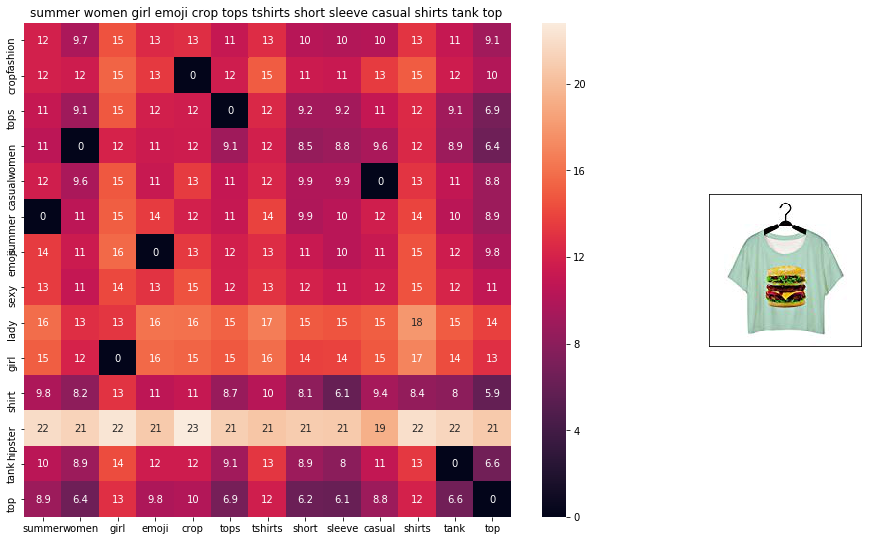

ASIN : B0124ECIU4
Brand : Doxi Supermall
euclidean distance from input : 2.55208


In [64]:
def weighted_w2v_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heat_map_w2v(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)

weighted_w2v_model(12566, 20)

# Weighted similarity using brand and color

In [65]:
# some of the brand values are empty. 
# Need to replace Null with string "NULL"
data['brand'].fillna(value="Not given", inplace=True )

# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

extra_features = hstack((brand_features, type_features, color_features)).tocsr()

In [66]:
def heat_map_w2v_brand(sentance1, sentance2, url, doc_id1, doc_id2, df_id1, df_id2, model):
    
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # df_id1: index of document1 in the data frame
    # df_id2: index of document2 in the data frame
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentance1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title2 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentance2, doc_id2, model)
    
    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)
   
    data_matrix = [['Asin','Brand', 'Color', 'Product type'],
               [data['asin'].loc[df_id1],brands[doc_id1], colors[doc_id1], types[doc_id1]], # input apparel's features
               [data['asin'].loc[df_id2],brands[doc_id2], colors[doc_id2], types[doc_id2]]] # recommonded apparel's features
    
    colorscale = [[0, '#1d004d'],[.5, '#f2e5ff'],[1, '#f2e5d1']] # to color the headings of each column 
    
    # we create a table with the data_matrix
    table = ff.create_table(data_matrix, index=True, colorscale=colorscale)
    # plot it with plotly
    plotly.offline.iplot(table, filename='simple_table')
    
    # devide whole figure space into 25 * 1:10 grids
    gs = gridspec.GridSpec(25, 15)
    fig = plt.figure(figsize=(25,5))
    
    # in first 25*10 grids we plot heatmap
    ax1 = plt.subplot(gs[:, :-5])
    # ploting the heap map based on the pairwise distances
    ax1 = sns.heatmap(np.round(s1_s2_dist,6), annot=True)
    # set the x axis labels as recommended apparels title
    ax1.set_xticklabels(sentance2.split())
    # set the y axis labels as input apparels title
    ax1.set_yticklabels(sentance1.split())
    # set title as recommended apparels title
    ax1.set_title(sentance2)

    # in last 25 * 10:15 grids we display image
    ax2 = plt.subplot(gs[:, 10:16])
    # we dont display grid lins and axis labels to images
    ax2.grid(False)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    # pass the url it display it
    display_img(url, ax2, fig)
    
    plt.show()

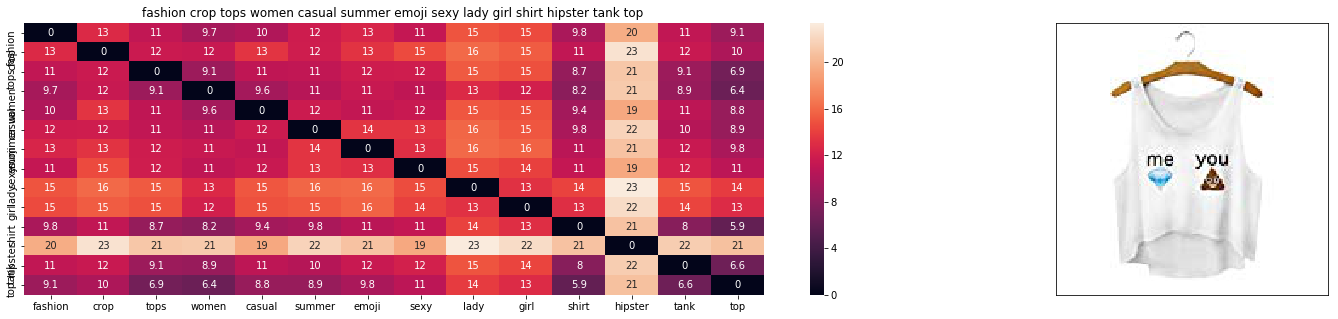

ASIN : B010V3B44G
Brand : Doxi Supermall
euclidean distance from input : 0.0009765625


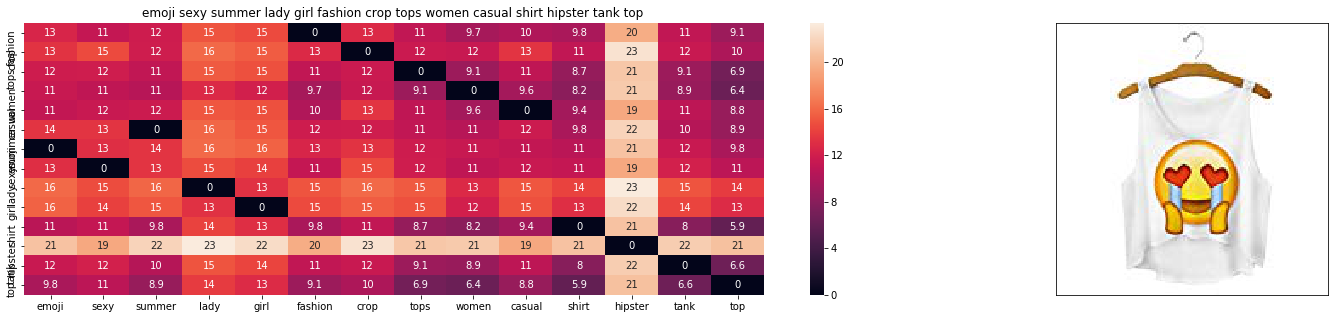

ASIN : B010V3BLWQ
Brand : Doxi Supermall
euclidean distance from input : 0.0009765625


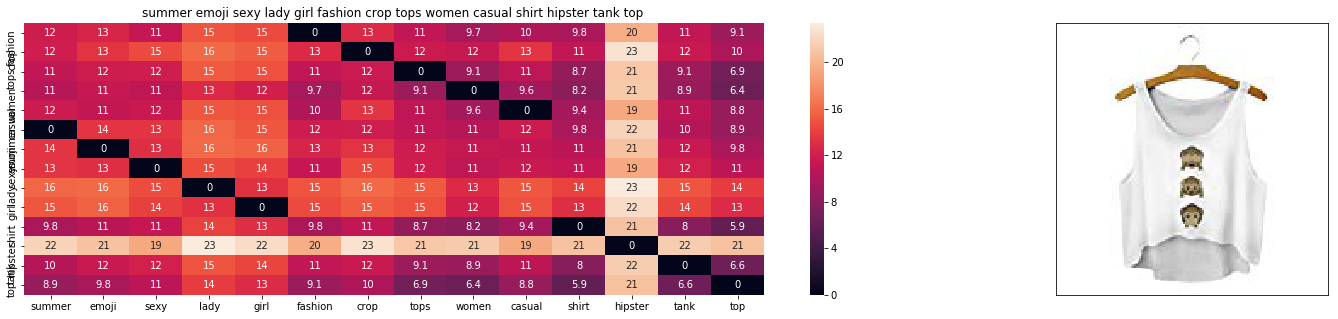

ASIN : B010V3BDII
Brand : Doxi Supermall
euclidean distance from input : 0.0009765625


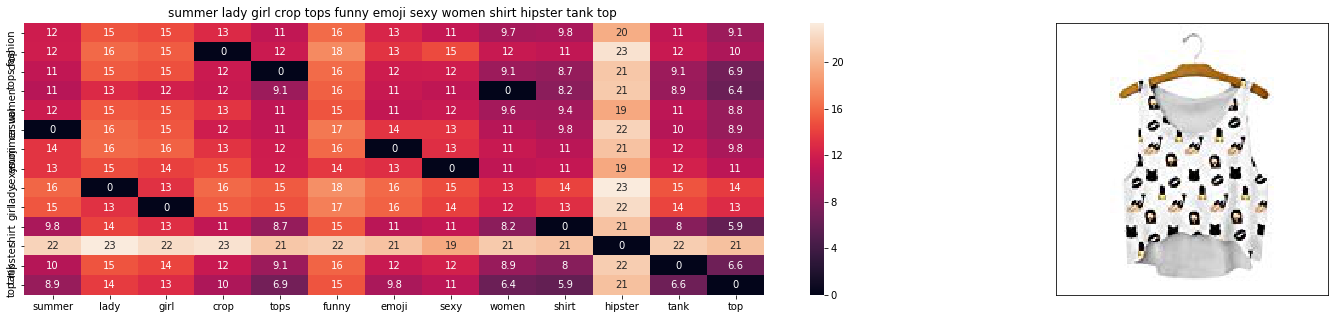

ASIN : B010V3BVMQ
Brand : Doxi Supermall
euclidean distance from input : 0.676524209976


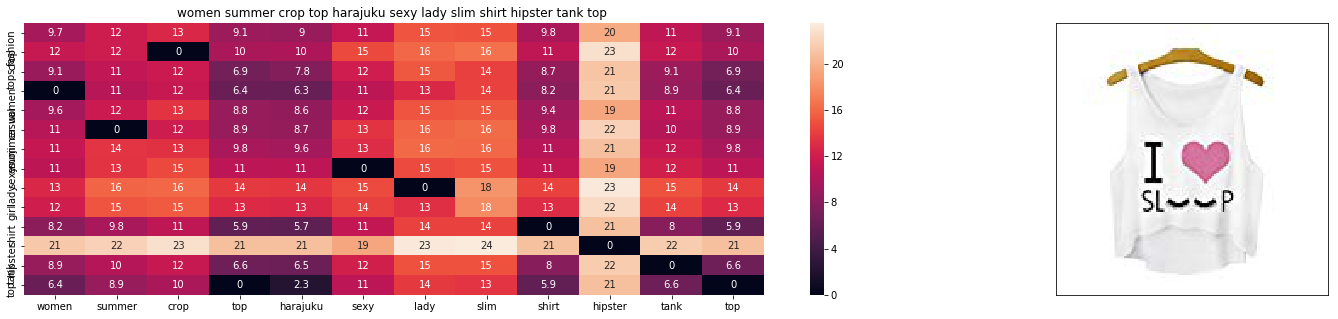

ASIN : B010V3EDEE
Brand : Doxi Supermall
euclidean distance from input : 0.871707439423


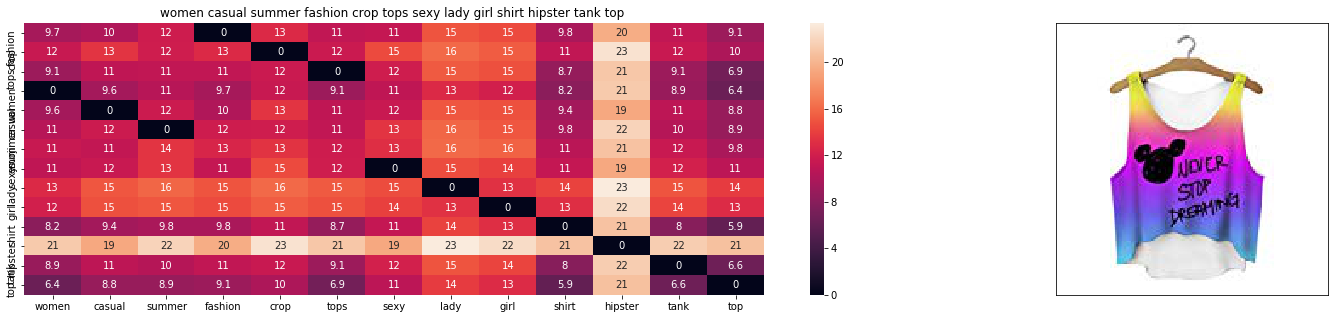

ASIN : B010V3AYSS
Brand : Doxi Supermall
euclidean distance from input : 1.05522220153


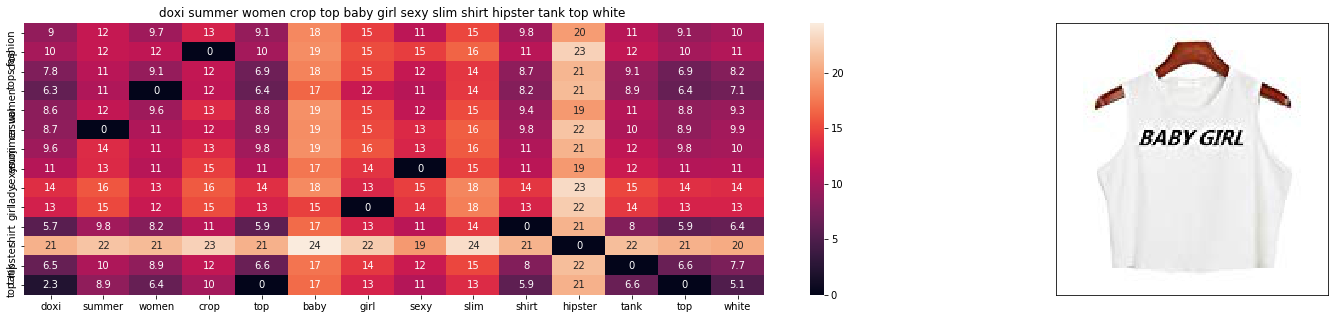

ASIN : B010V3A23U
Brand : Doxi Supermall
euclidean distance from input : 1.06218442917


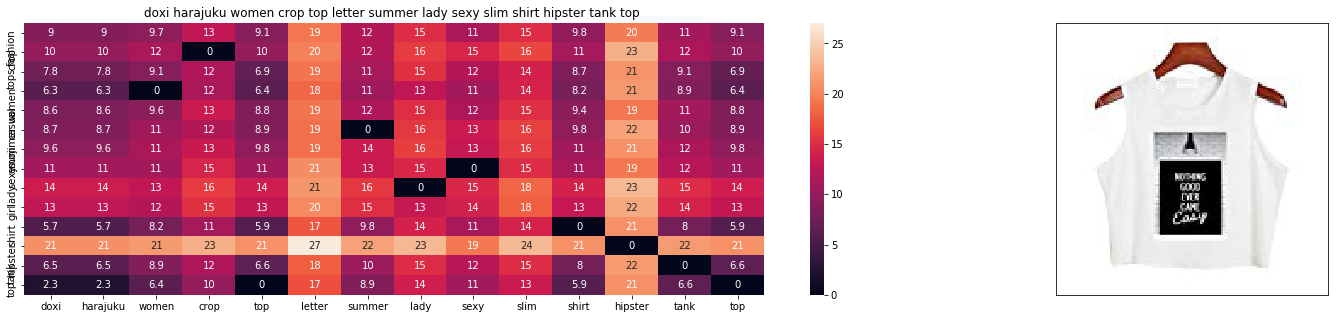

ASIN : B010V380LQ
Brand : Doxi Supermall
euclidean distance from input : 1.08374633789


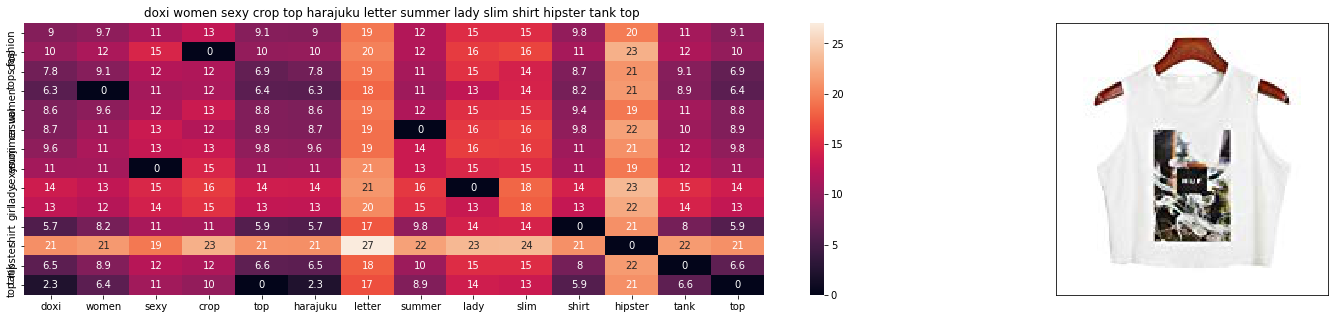

ASIN : B010V39146
Brand : Doxi Supermall
euclidean distance from input : 1.08374633789


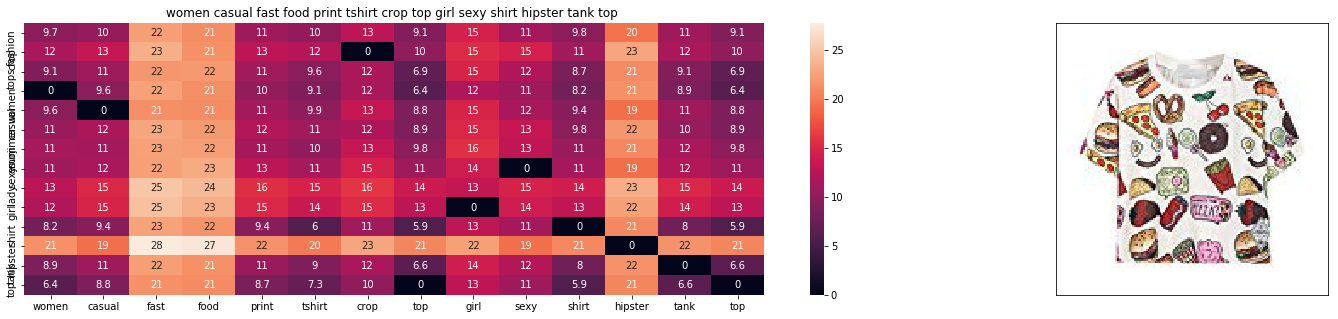

ASIN : B010V3AB5O
Brand : Doxi Supermall
euclidean distance from input : 1.31359004974


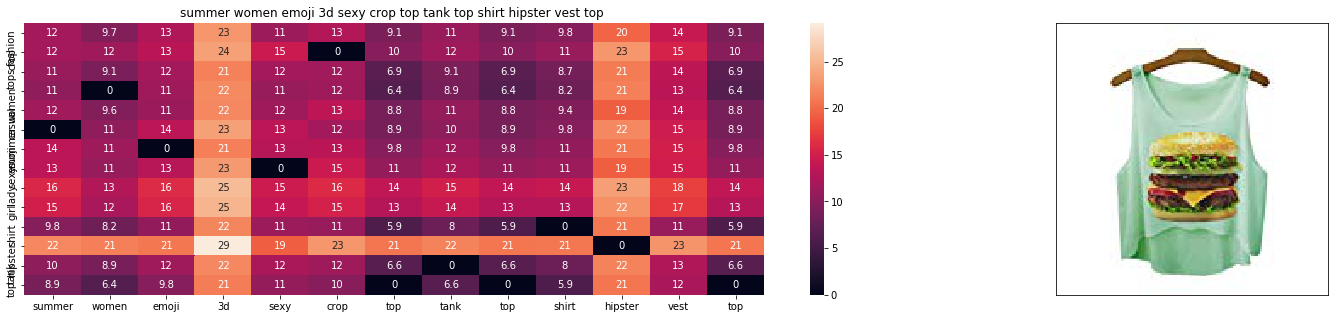

ASIN : B010V3E5EC
Brand : Doxi Supermall
euclidean distance from input : 1.33973503113


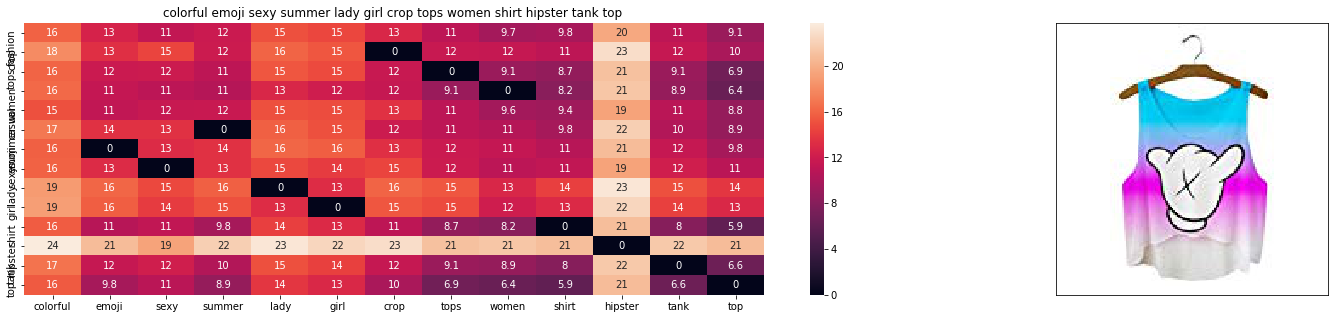

ASIN : B010V3BQZS
Brand : Doxi Supermall
euclidean distance from input : 1.35074257869


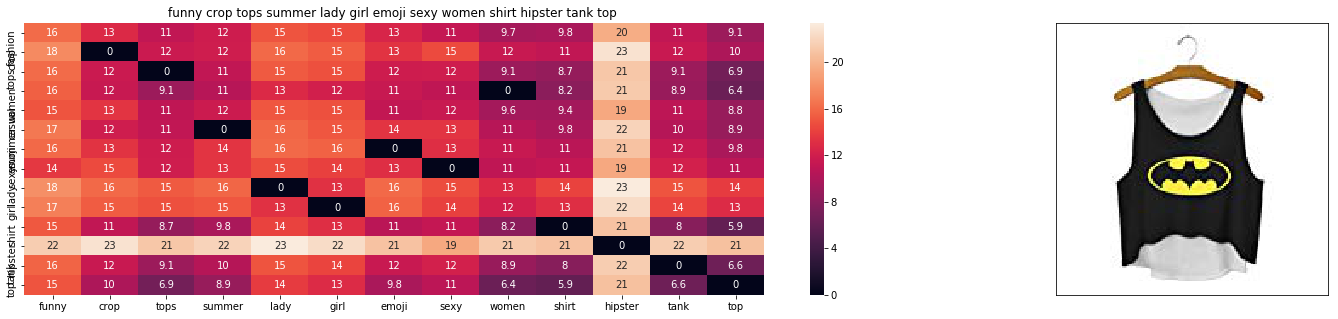

ASIN : B010V3C116
Brand : Doxi Supermall
euclidean distance from input : 1.38363099116


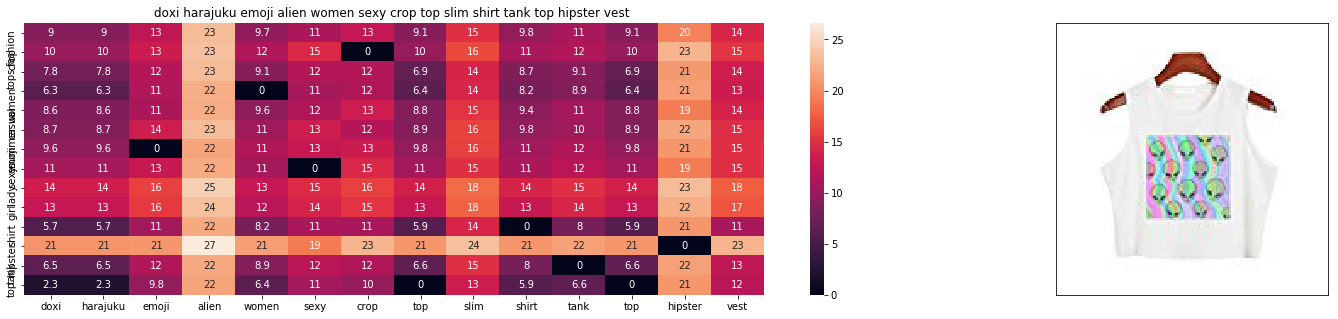

ASIN : B010TKXAI4
Brand : Doxi Supermall
euclidean distance from input : 1.38760099411


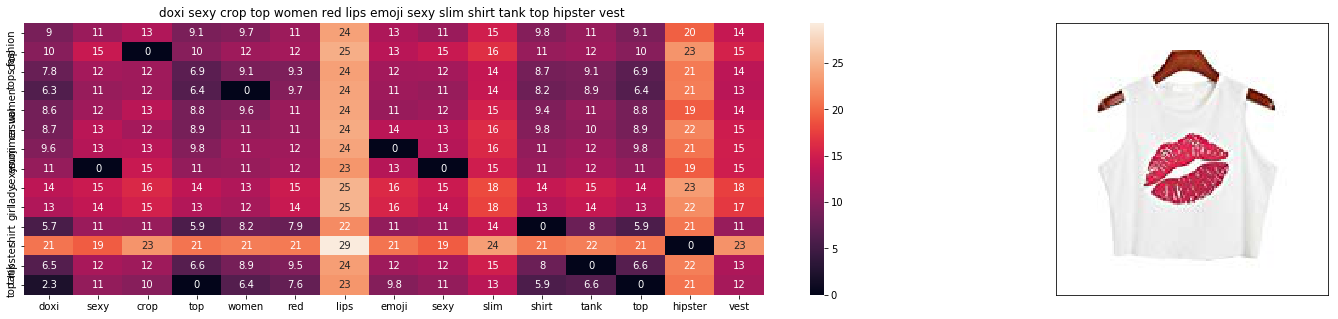

ASIN : B010TKXEHG
Brand : Doxi Supermall
euclidean distance from input : 1.42695598602


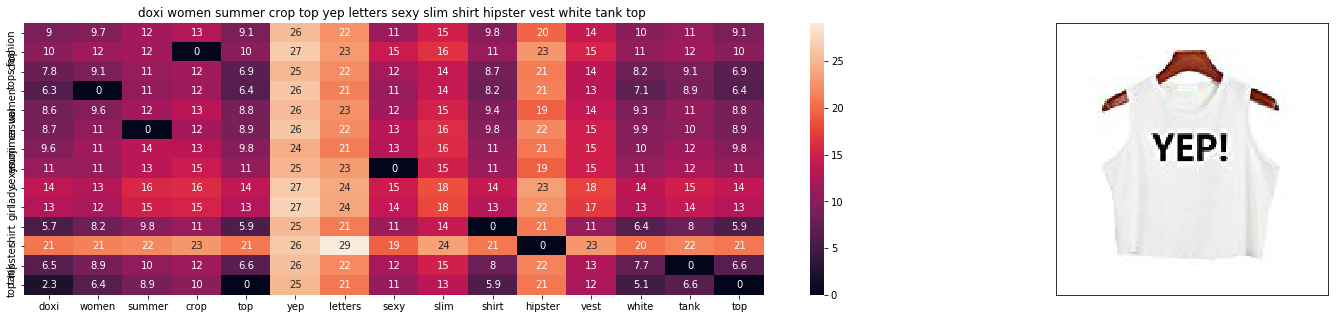

ASIN : B010V3487Q
Brand : Doxi Supermall
euclidean distance from input : 1.46818675995


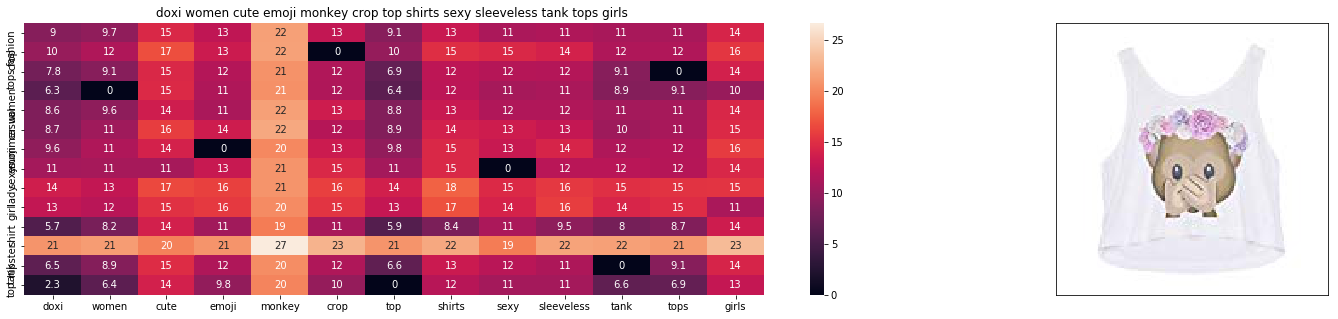

ASIN : B01LF90QTO
Brand : Doxi Supermall
euclidean distance from input : 1.47615346909


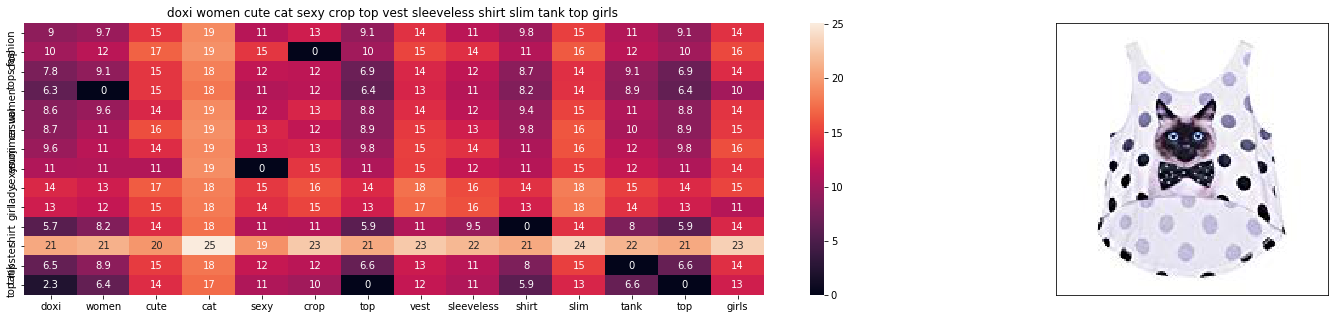

ASIN : B01LF90ROI
Brand : Doxi Supermall
euclidean distance from input : 1.48217487335


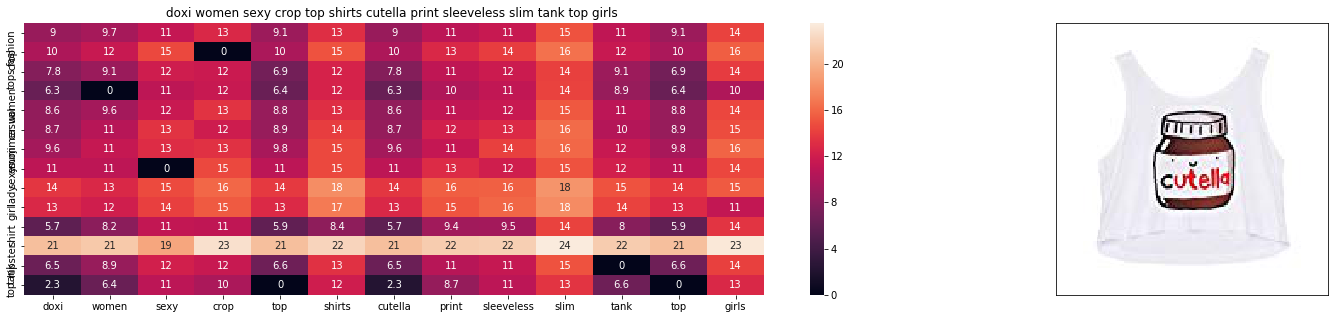

ASIN : B01LF90RKC
Brand : Doxi Supermall
euclidean distance from input : 1.50589389801


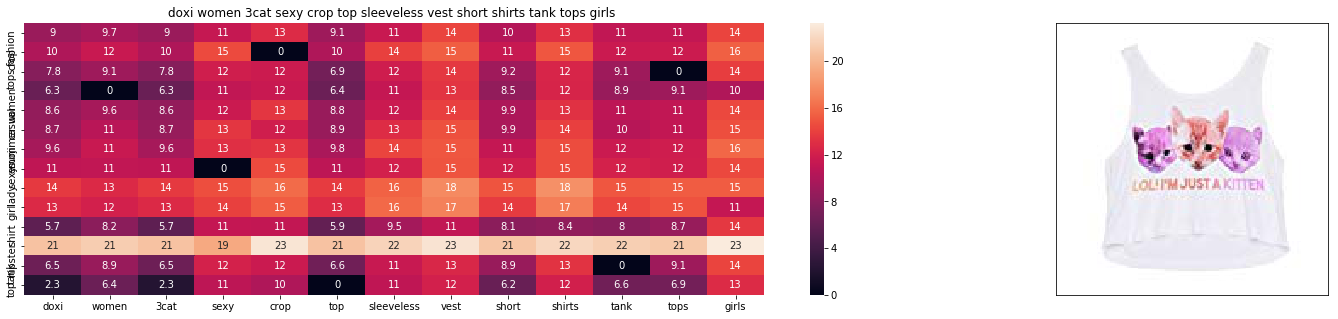

ASIN : B01LY4GQY0
Brand : Doxi Supermall
euclidean distance from input : 1.50981807709


In [67]:
def idf_w2v_brand(doc_id, w1, w2, num_results):
    # doc_id: apparel's id in given corpus
    # w1: weight for  w2v features
    # w2: weight for brand and color features

    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    ex_feat_dist = pairwise_distances(extra_features, extra_features[doc_id])
    pairwise_dist   = (w1 * idf_w2v_dist +  w2 * ex_feat_dist)/float(w1 + w2)

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    

    for i in range(0, len(indices)):
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)

idf_w2v_brand(12566, 5, 5, 20)

# Keras and Tensorflow to extract features

In [3]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import requests
from PIL import Image
import pandas as pd
import pickle

# Visual features based product similarity

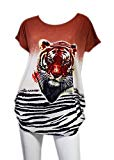

Product Title:  burnt umber tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 0.0625
Amazon Url: www.amzon.com/dp/B00JXQB5FQ


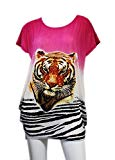

Product Title:  pink tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 30.050072
Amazon Url: www.amzon.com/dp/B00JXQASS6


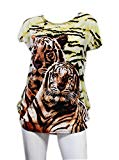

Product Title:  yellow tiger tshirt tiger stripes  l 
Euclidean Distance from input image: 41.261078
Amazon Url: www.amzon.com/dp/B00JXQCUIC


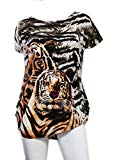

Product Title:  brown  white tiger tshirt tiger stripes xl  xxl 
Euclidean Distance from input image: 44.000187
Amazon Url: www.amzon.com/dp/B00JXQCWTO


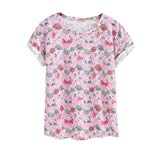

Product Title:  kawaii pastel tops tees pink flower design 
Euclidean Distance from input image: 47.38251
Amazon Url: www.amzon.com/dp/B071FCWD97


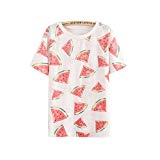

Product Title:  womens thin style tops tees pastel watermelon print 
Euclidean Distance from input image: 47.718403
Amazon Url: www.amzon.com/dp/B01JUNHBRM


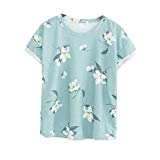

Product Title:  kawaii pastel tops tees baby blue flower design 
Euclidean Distance from input image: 47.9021
Amazon Url: www.amzon.com/dp/B071SBCY9W


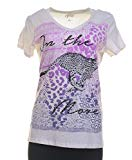

Product Title:  edv cheetah run purple multi xl 
Euclidean Distance from input image: 48.046516
Amazon Url: www.amzon.com/dp/B01CUPYBM0


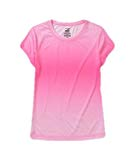

Product Title:  danskin womens vneck loose performance tee xsmall pink ombre 
Euclidean Distance from input image: 48.101917
Amazon Url: www.amzon.com/dp/B01F7PHXY8


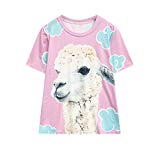

Product Title:  summer alpaca 3d pastel casual loose tops tee design 
Euclidean Distance from input image: 48.118877
Amazon Url: www.amzon.com/dp/B01I80A93G


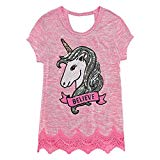

Product Title:  miss chievous juniors striped peplum tank top medium shadowpeach 
Euclidean Distance from input image: 48.13129
Amazon Url: www.amzon.com/dp/B0177DM70S


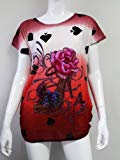

Product Title:  red  pink floral heel sleeveless shirt xl  xxl 
Euclidean Distance from input image: 48.16947
Amazon Url: www.amzon.com/dp/B00JV63QQE


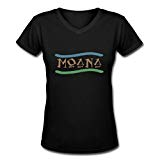

Product Title:  moana logo adults hot v neck shirt black xxl 
Euclidean Distance from input image: 48.25679
Amazon Url: www.amzon.com/dp/B01LX6H43D


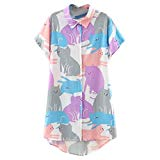

Product Title:  abaday multicolor cartoon cat print short sleeve longline shirt large 
Euclidean Distance from input image: 48.265633
Amazon Url: www.amzon.com/dp/B01CR57YY0


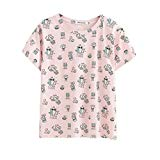

Product Title:  kawaii cotton pastel tops tees peach pink cactus design 
Euclidean Distance from input image: 48.362583
Amazon Url: www.amzon.com/dp/B071WYLBZS


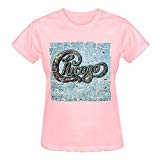

Product Title:  chicago chicago 18 shirt women pink 
Euclidean Distance from input image: 48.383617
Amazon Url: www.amzon.com/dp/B01GXAZTRY


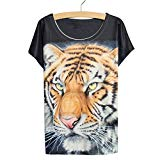

Product Title:  yichun womens tiger printed summer tshirts tops 
Euclidean Distance from input image: 48.449303
Amazon Url: www.amzon.com/dp/B010NN9RXO


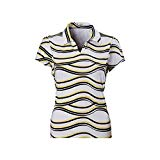

Product Title:  nancy lopez whimsy short sleeve  whiteblacklemon drop  xs 
Euclidean Distance from input image: 48.478912
Amazon Url: www.amzon.com/dp/B01MPX6IDX


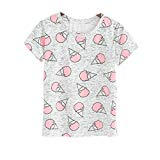

Product Title:  womens tops tees pastel peach ice cream cone print 
Euclidean Distance from input image: 48.557964
Amazon Url: www.amzon.com/dp/B0734GRKZL


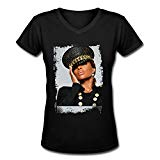

Product Title:  uswomens mary j blige without tshirts shirt 
Euclidean Distance from input image: 48.614376
Amazon Url: www.amzon.com/dp/B01M0XXFKK


In [4]:
#load the features and corresponding ASINS info.
bottleneck_features_train = np.load('16k_data_cnn_features.npy')
asins = np.load('16k_data_cnn_feature_asins.npy')
asins = list(asins)

# load the original 16K dataset
data = pd.read_pickle('pickles/16k_apperal_data_preprocessed')
df_asins = list(data['asin'])


from IPython.display import display, Image, SVG, Math, YouTubeVideo


#get similar products using CNN features (VGG-16)
def get_similar_products_cnn(doc_id, num_results):
    doc_id = asins.index(df_asins[doc_id])
    pairwise_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    for i in range(len(indices)):
        rows = data[['medium_image_url','title']].loc[data['asin']==asins[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['medium_image_url'], embed=True))
            print('Product Title: ', row['title'])
            print('Euclidean Distance from input image:', pdists[i])
            print('Amazon Url: www.amzon.com/dp/'+ asins[indices[i]])

get_similar_products_cnn(12566, 20)